# 📡 Markov Transition Field (MTF) — Deep Analysis & Bayesian Optimization

---

## 🧠 What is a Markov Transition Field?

A **Markov Transition Field (MTF)** transforms a 1-D time series into a **2-D image** that encodes its **probabilistic transition dynamics** — making it usable with image-based ML models (CNNs, ViTs).

### Pipeline

```
Raw Time Series  ──▶  Discretize into Q bins  ──▶  Markov Transition Matrix (Q×Q)
                                                         │
              ┌──────────────────────────────────────────┘
              ▼
         MTF[i,j] = MTM[ bin(tᵢ), bin(tⱼ) ]    ← N×N image
              │
              ▼
        Downsample  ──▶  Self-Transition Analysis  ──▶  Visualize
```

### Key Equation

$$MTF[i,j] = MTM[q_i,\, q_j], \quad \text{where } q_i = \text{bin assigned to } x_i$$

### Why MTF over other encodings?
| Method | Captures | Loses |
|--------|----------|-------|
| **MTF** | Markovian transition dynamics, temporal ordering | Exact amplitude values |
| GAF | Geometric shape, amplitude | Transition probabilities |
| RP  | Recurrence patterns | Probabilistic structure |

---
> **Dataset:** ETTh1 — Electricity Transformer Temperature (hourly, China power grid)  
> **Target:** `HUFL` — High Useful Load


## 1. 📦 Libraries & Configuration

> All libraries used in this notebook. `pyts` handles quantile discretization; `skimage` handles block-reduce downsampling; `scipy` powers the Bayesian GP surrogate.

In [2]:
!pip install -q pyts scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib import cm, colors
from scipy import stats
from scipy.stats import gaussian_kde, norm as sp_norm
from skimage import measure as sm
from pyts.preprocessing.discretizer import KBinsDiscretizer

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   '#F7F9FC',
    'axes.grid':        True,
    'grid.alpha':       0.35,
    'grid.linestyle':   '--',
    'font.size':        11,
    'axes.titlesize':   13,
    'axes.labelsize':   11,
    'axes.spines.top':  False,
    'axes.spines.right':False,
})

SEED = 42
np.random.seed(SEED)
print("✅ Environment ready.")


✅ Environment ready.


---
## 2. 📂 Dataset — ETTh1 (Electricity Transformer Temperature)

| Column | Description | Type |
|--------|-------------|------|
| `date` | Hourly timestamp | Datetime |
| `HUFL` | **High Useful Load** ← *our target* | Float |
| `HULL` | High Useless Load | Float |
| `MUFL` | Medium Useful Load | Float |
| `MULL` | Medium Useless Load | Float |
| `LUFL` | Low Useful Load | Float |
| `LULL` | Low Useless Load | Float |
| `OT`   | Oil Temperature | Float |

> **17,420 hourly records** spanning ~2 years of a Chinese power grid.

In [4]:
URL = 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv'
df = pd.read_csv(URL, parse_dates=['date'])

print(f"Shape      : {df.shape}")
print(f"Date range : {df['date'].min()}  →  {df['date'].max()}")
print(f"Nulls      :\n{df.isnull().sum()}")


Shape      : (17420, 8)
Date range : 2016-07-01 00:00:00  →  2018-06-26 19:00:00
Nulls      :
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


### 2.1 First Look

In [5]:
df.head(8)

date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
5 2016-07-01 05:00:00  5.626  2.143  1.528  0.533  4.051  1.371  21.174000
6 2016-07-01 06:00:00  7.167  2.947  2.132  0.782  5.026  1.858  22.792000
7 2016-07-01 07:00:00  7.435  3.282  2.310  1.031  5.087  2.224  23.143999

### 2.2 Descriptive Statistics

In [6]:
desc = df.describe().T
desc['cv'] = desc['std'] / desc['mean']   # Coefficient of Variation
desc.round(3)


count                 mean                  min                  25%  \
date    17420  2017-06-28 21:30:00  2016-07-01 00:00:00  2016-12-29 10:45:00   
HUFL  17420.0             7.375141           -22.705999                5.827   
HULL  17420.0             2.242242               -4.756                0.737   
MUFL  17420.0             4.300239           -25.087999                3.296   
MULL  17420.0             0.881568               -5.934               -0.284   
LUFL  17420.0             3.066062               -1.188                2.315   
LULL  17420.0             0.856932               -1.371                 0.67   
OT    17420.0            13.324672                -4.08                6.964   

                      50%                  75%                  max       std  \
date  2017-06-28 21:30:00  2017-12-27 08:15:00  2018-06-26 19:00:00       NaN   
HUFL                8.774               11.788            23.643999  7.067744   
HULL                 2.21                3.684               10.114  2.042342   
MUFL                 5.97                8.635               17.341  6.826978   
MULL                0.959                2.203                7.747  1.809293   
LUFL                2.833                3.625                8.498  1.164506   
LULL                0.975                1.218                3.046  0.599552   
OT                 11.396               18.079               46.007  8.566946   

            cv  
date       NaN  
HUFL   0.95832  
HULL  0.910848  
MUFL  1.587581  
MULL  2.052359  
LUFL  0.379805  
LULL  0.699649  
OT    0.642939

### 2.3 Data Types & Memory

In [7]:
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")


date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object

Memory usage: 1088.9 KB


---
## 3. 🔍 Exploratory Data Analysis

> We first explore the **full dataset** (17 420 rows) to understand global patterns, then narrow down to the **first 1 000 rows** used for MTF construction.

### 3.1 All Features — Raw Time Series

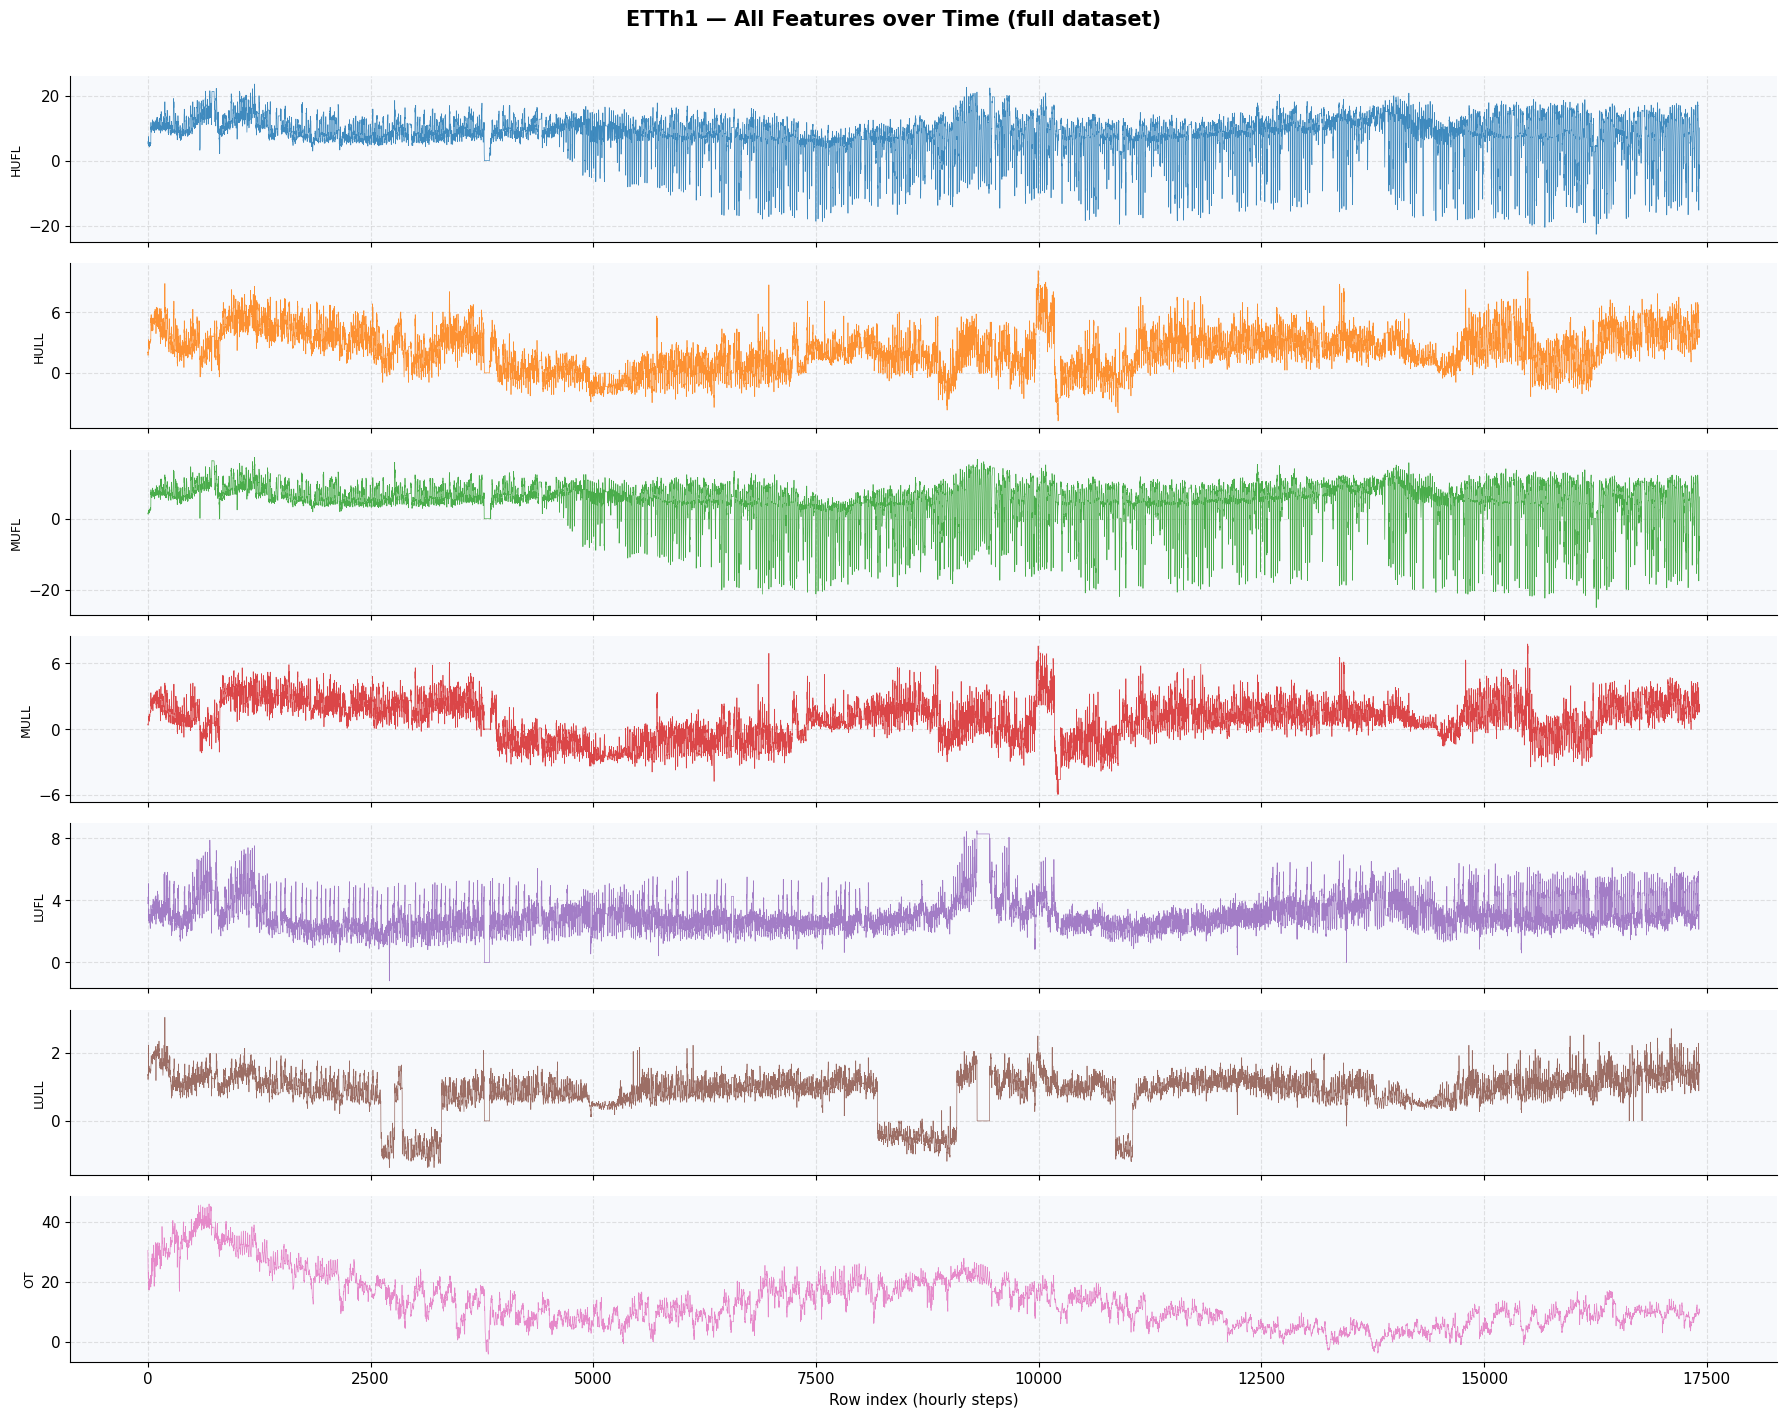

In [8]:
numeric_cols = [c for c in df.columns if c != 'date']
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(18, 14), sharex=True)
fig.suptitle("ETTh1 — All Features over Time (full dataset)", fontsize=15, fontweight='bold', y=1.01)

palette = sns.color_palette("tab10", len(numeric_cols))
for ax, col, color in zip(axes, numeric_cols, palette):
    ax.plot(df.index, df[col], color=color, linewidth=0.5, alpha=0.85)
    ax.set_ylabel(col, fontsize=9)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(3))

axes[-1].set_xlabel("Row index (hourly steps)")
plt.tight_layout()
plt.show()


### 3.2 Truncate to First 1 000 Rows

> All subsequent EDA and MTF construction use this subset.

In [9]:
ett = df.iloc[:1000].copy().reset_index(drop=True)

# Use integer index as x-axis for robustness across all plot types
# date column is kept but we use .index for plotting
print(f"Working subset shape : {ett.shape}")
print(f"Date range           : {ett['date'].iloc[0]}  →  {ett['date'].iloc[-1]}")


Working subset shape : (1000, 8)
Date range           : 2016-07-01 00:00:00  →  2016-08-11 15:00:00


### 3.3 HUFL — Raw Signal

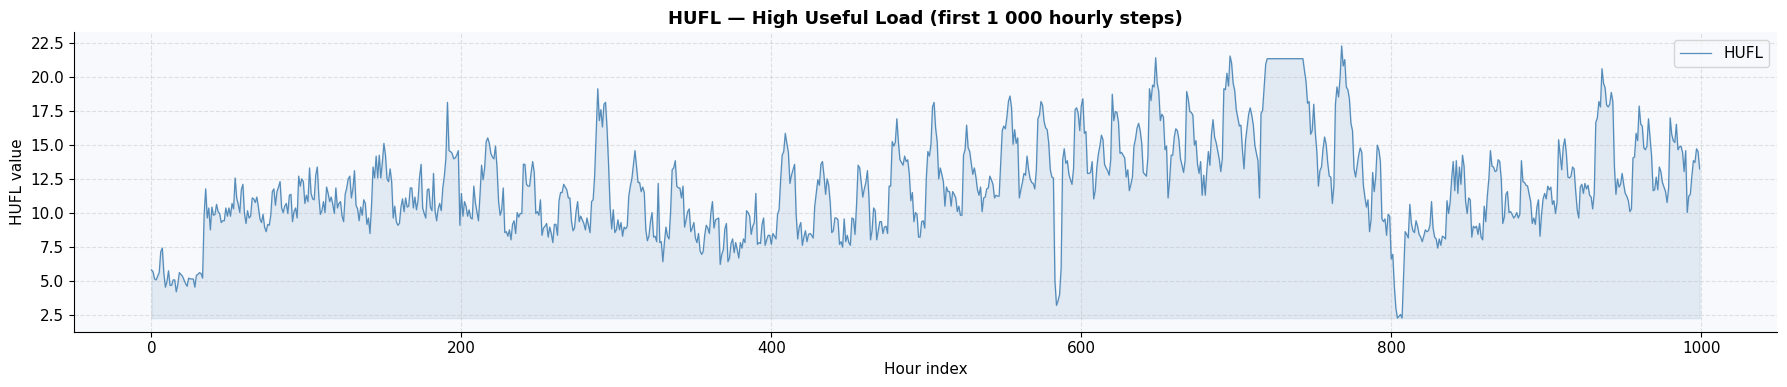

In [10]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(ett.index, ett['HUFL'], color='steelblue', linewidth=0.9, alpha=0.9, label='HUFL')
ax.fill_between(ett.index,
                ett['HUFL'].min(),
                ett['HUFL'],
                alpha=0.12, color='steelblue')
ax.set_title("HUFL — High Useful Load (first 1 000 hourly steps)", fontweight='bold')
ax.set_xlabel("Hour index")
ax.set_ylabel("HUFL value")
ax.legend()
plt.tight_layout()
plt.show()


### 3.4 Distribution Analysis — Histogram, KDE & Box-Violin

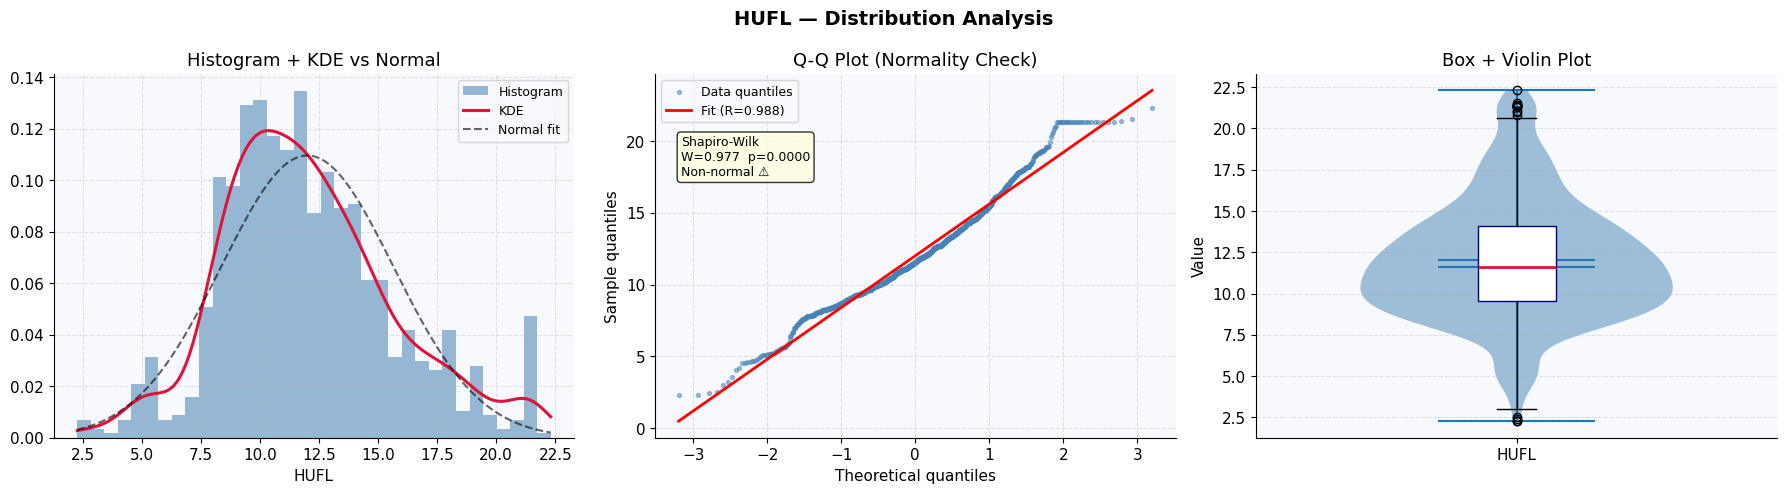

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("HUFL — Distribution Analysis", fontsize=14, fontweight='bold')

# ── Histogram + KDE ───────────────────────────────────────
ax = axes[0]
ax.hist(ett['HUFL'], bins=35, density=True, color='steelblue', alpha=0.55, label='Histogram')
x_grid = np.linspace(ett['HUFL'].min(), ett['HUFL'].max(), 300)
kde = gaussian_kde(ett['HUFL'])
ax.plot(x_grid, kde(x_grid), color='crimson', lw=2.2, label='KDE')
mu, sigma = ett['HUFL'].mean(), ett['HUFL'].std()
ax.plot(x_grid, sp_norm.pdf(x_grid, mu, sigma), 'k--', lw=1.5, alpha=0.6, label='Normal fit')
ax.set_title("Histogram + KDE vs Normal")
ax.set_xlabel("HUFL")
ax.legend(fontsize=9)

# ── Q-Q Plot ──────────────────────────────────────────────
ax = axes[1]
(osm, osr), (slope, intercept, r) = stats.probplot(ett['HUFL'], dist='norm', fit=True)
ax.scatter(osm, osr, s=8, color='steelblue', alpha=0.5, label='Data quantiles')
qq_line = np.array([min(osm), max(osm)])
ax.plot(qq_line, slope * qq_line + intercept, 'r-', lw=2, label=f'Fit (R={r:.3f})')
ax.set_title("Q-Q Plot (Normality Check)")
ax.set_xlabel("Theoretical quantiles")
ax.set_ylabel("Sample quantiles")
ax.legend(fontsize=9)

# Shapiro-Wilk test (on a subsample for speed)
sample = ett['HUFL'].sample(min(500, len(ett)), random_state=42)
stat, p = stats.shapiro(sample)
ax.annotate(f"Shapiro-Wilk\nW={stat:.3f}  p={p:.4f}\n{'Normal ✅' if p>0.05 else 'Non-normal ⚠️'}",
            xy=(0.05, 0.72), xycoords='axes fraction', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

# ── Box + Violin ──────────────────────────────────────────
ax = axes[2]
parts = ax.violinplot(ett['HUFL'], positions=[1], widths=0.6,
                      showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_alpha(0.5)
ax.boxplot(ett['HUFL'], positions=[1], widths=0.15, patch_artist=True,
           boxprops=dict(facecolor='white', color='navy'),
           medianprops=dict(color='crimson', lw=2))
ax.set_title("Box + Violin Plot")
ax.set_xticks([1])
ax.set_xticklabels(['HUFL'])
ax.set_ylabel("Value")

plt.tight_layout()
plt.show()


> **📌 Insight:** If `p < 0.05` in Shapiro-Wilk, the distribution is **non-normal** — this validates using *quantile* binning (not uniform) for the MTF, as quantile bins don't assume normality.

### 3.5 Seasonal / Temporal Patterns — Hour-of-Day & Day-of-Week

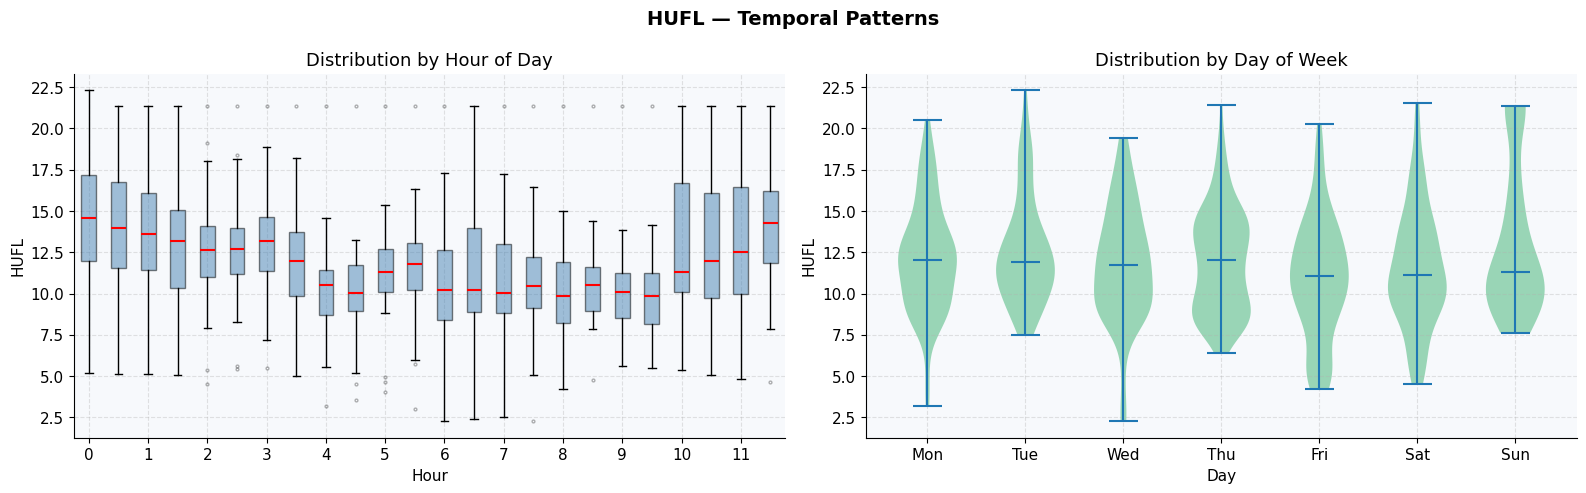

In [12]:
ett_ts = ett.copy()
ett_ts['hour']       = ett_ts['date'].dt.hour
ett_ts['dayofweek']  = ett_ts['date'].dt.dayofweek  # 0=Mon

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("HUFL — Temporal Patterns", fontsize=14, fontweight='bold')

# ── Hourly box plots ─────────────────────────────────────
hourly_groups = [ett_ts[ett_ts['hour'] == h]['HUFL'].values for h in range(24)]
axes[0].boxplot(hourly_groups, positions=range(24), widths=0.5, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.5),
                medianprops=dict(color='red', lw=1.5),
                flierprops=dict(marker='o', markersize=2, alpha=0.3))
axes[0].set_title("Distribution by Hour of Day")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("HUFL")
axes[0].set_xticks(range(0, 24, 2))

# ── Day-of-week violin ────────────────────────────────────
day_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
day_groups = [ett_ts[ett_ts['dayofweek'] == d]['HUFL'].values for d in range(7)]
day_groups = [g for g in day_groups if len(g) > 0]
valid_days = [day_labels[d] for d in range(7) if len(ett_ts[ett_ts['dayofweek'] == d]) > 0]
parts = axes[1].violinplot(day_groups, positions=range(len(day_groups)), widths=0.6, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('mediumseagreen')
    pc.set_alpha(0.5)
axes[1].set_xticks(range(len(valid_days)))
axes[1].set_xticklabels(valid_days)
axes[1].set_title("Distribution by Day of Week")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("HUFL")

plt.tight_layout()
plt.show()


### 3.6 Rolling Statistics — Trend & Volatility

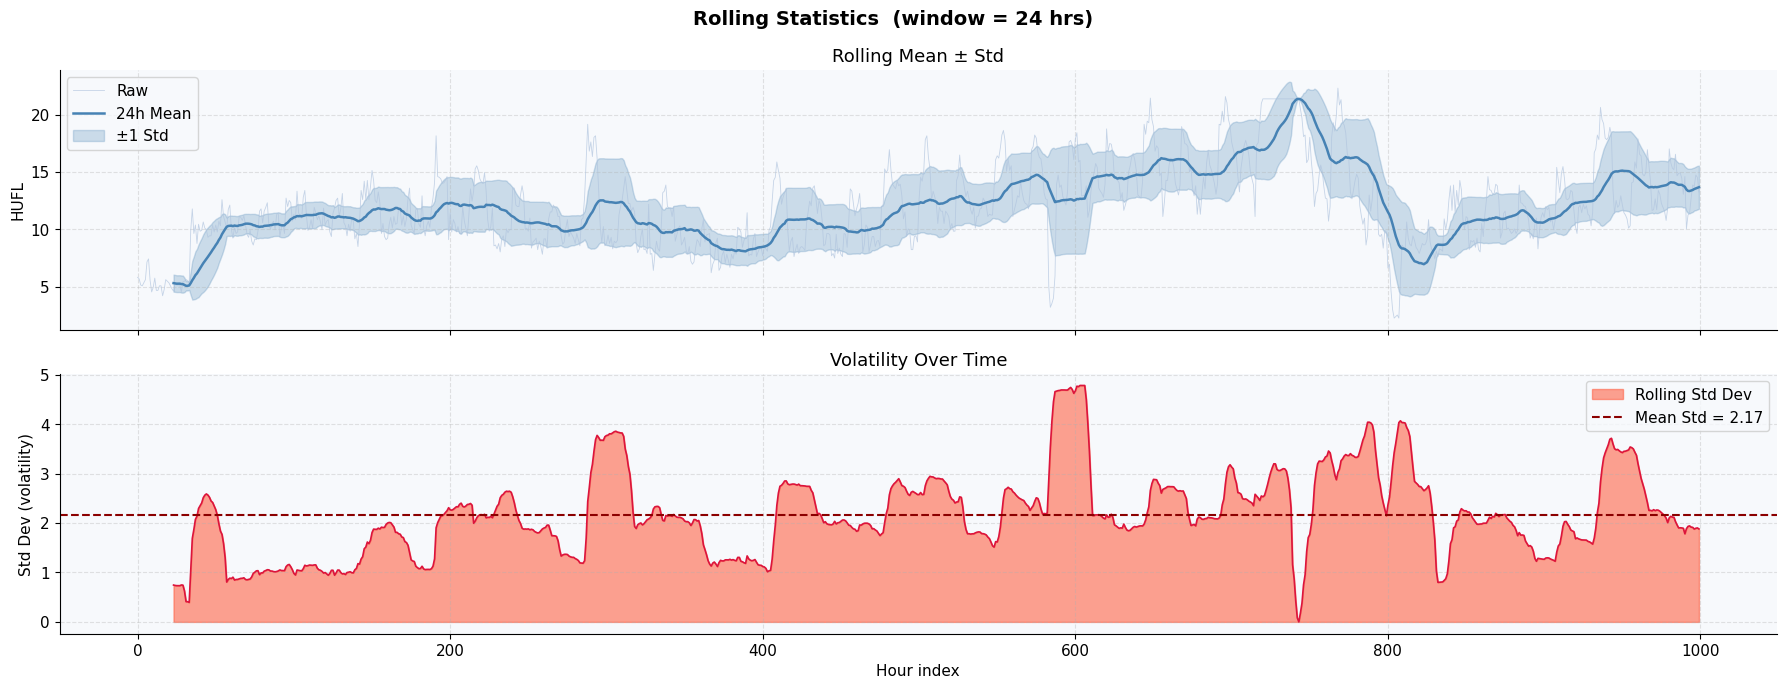

In [13]:
window = 24   # 24-hour rolling window

roll_mean = ett['HUFL'].rolling(window).mean()
roll_std  = ett['HUFL'].rolling(window).std()

fig, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=True)
fig.suptitle(f"Rolling Statistics  (window = {window} hrs)", fontsize=14, fontweight='bold')

# ── Mean ─────────────────────────────────────────────────
axes[0].plot(ett.index, ett['HUFL'], color='lightsteelblue', lw=0.6, alpha=0.7, label='Raw')
axes[0].plot(ett.index, roll_mean, color='steelblue', lw=1.8, label=f'{window}h Mean')
axes[0].fill_between(ett.index,
                     roll_mean - roll_std,
                     roll_mean + roll_std,
                     alpha=0.25, color='steelblue', label='±1 Std')
axes[0].set_ylabel("HUFL")
axes[0].set_title("Rolling Mean ± Std")
axes[0].legend()

# ── Volatility ────────────────────────────────────────────
axes[1].fill_between(ett.index, 0, roll_std, color='tomato', alpha=0.6, label='Rolling Std Dev')
axes[1].plot(ett.index, roll_std, color='crimson', lw=1.2)
axes[1].axhline(roll_std.mean(), color='darkred', lw=1.5, ls='--', label=f'Mean Std = {roll_std.mean():.2f}')
axes[1].set_ylabel("Std Dev (volatility)")
axes[1].set_xlabel("Hour index")
axes[1].set_title("Volatility Over Time")
axes[1].legend()

plt.tight_layout()
plt.show()


### 3.7 Correlation Analysis — All Features

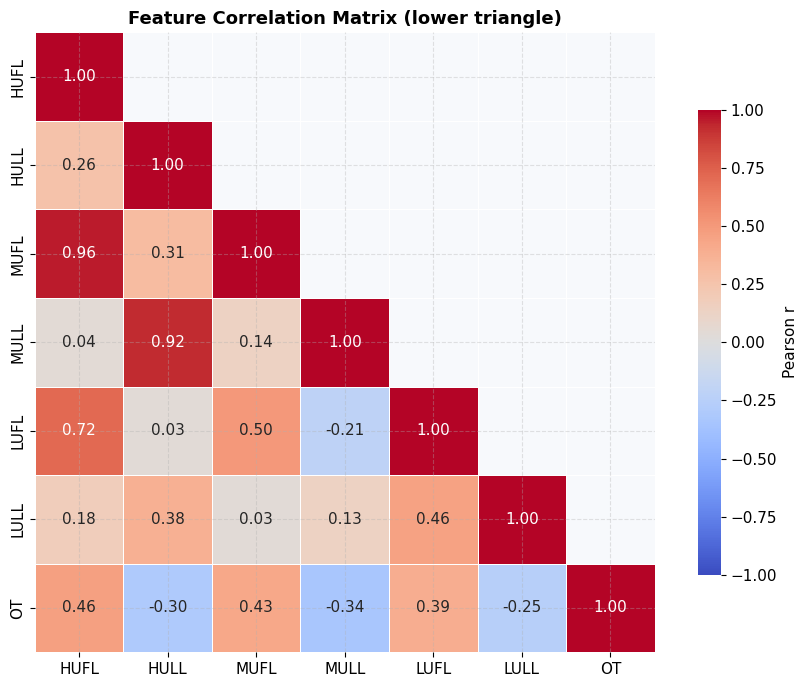

In [14]:
corr_matrix = ett[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)   # upper triangle

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1,
            mask=mask,
            linewidths=0.5, linecolor='white',
            square=True, ax=ax,
            cbar_kws={'label': 'Pearson r', 'shrink': 0.75})
ax.set_title("Feature Correlation Matrix (lower triangle)", fontweight='bold')
plt.tight_layout()
plt.show()


> **📌 Insight:** High correlations between load features suggest they carry redundant information. This matters for MTF: encoding a highly correlated feature would produce a structurally similar MTF. `OT` (oil temperature) often shows distinct behavior.

### 3.8 Autocorrelation & Partial Autocorrelation (ACF / PACF)

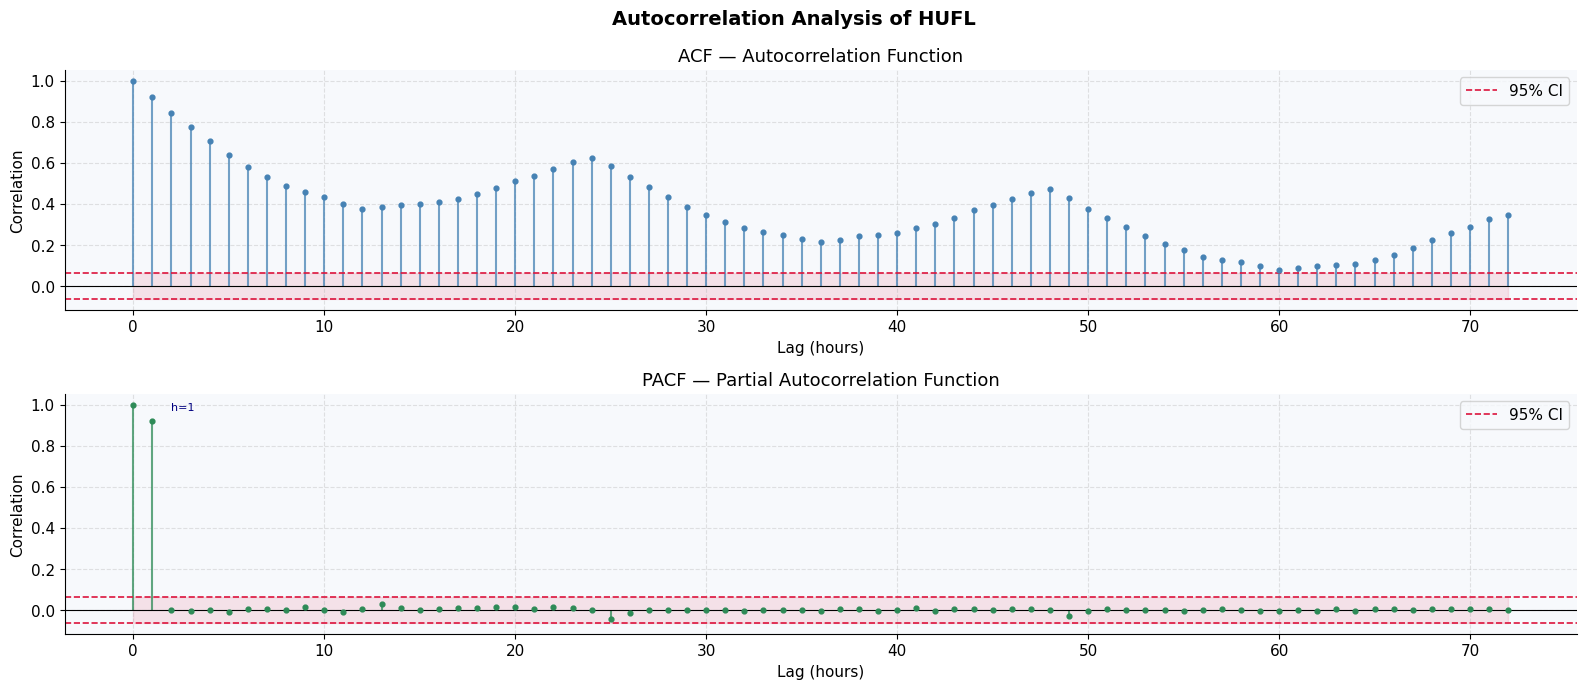

Significant ACF lags (|r| > 95% CI): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ...


In [15]:
def manual_acf(series, max_lags=48):
    """Compute ACF without statsmodels."""
    x = series.values - series.mean()
    n = len(x)
    acf_vals = np.array([
        np.dot(x[:n-k], x[k:]) / np.dot(x, x)
        for k in range(max_lags + 1)
    ])
    conf = 1.96 / np.sqrt(n)   # 95% confidence band
    return acf_vals, conf

def manual_pacf(series, max_lags=48):
    """Compute PACF via Yule-Walker equations."""
    acf_vals, conf = manual_acf(series, max_lags)
    pacf_vals = np.zeros(max_lags + 1)
    pacf_vals[0] = 1.0
    for k in range(1, max_lags + 1):
        r = acf_vals[1:k+1]
        if k == 1:
            pacf_vals[k] = r[0]
        else:
            R = np.array([[acf_vals[abs(i-j)] for j in range(k-1)] for i in range(k-1)])
            try:
                phi = np.linalg.solve(R, r[:k-1])
                pacf_vals[k] = (r[k-1] - np.dot(phi, r[:k-1][::-1]))
            except np.linalg.LinAlgError:
                pacf_vals[k] = 0
    return pacf_vals, conf

max_lags = 72
acf_vals, conf_acf   = manual_acf(ett['HUFL'],  max_lags)
pacf_vals, conf_pacf = manual_pacf(ett['HUFL'], max_lags)

fig, axes = plt.subplots(2, 1, figsize=(16, 7))
fig.suptitle("Autocorrelation Analysis of HUFL", fontsize=14, fontweight='bold')

lags = np.arange(max_lags + 1)
for ax, vals, title, color in zip(axes,
                                   [acf_vals, pacf_vals],
                                   ['ACF — Autocorrelation Function',
                                    'PACF — Partial Autocorrelation Function'],
                                   ['steelblue', 'seagreen']):
    ax.vlines(lags, 0, vals, color=color, lw=1.5, alpha=0.75)
    ax.axhline(0,         color='black', lw=0.8)
    ax.axhline( conf_acf, color='crimson', lw=1.2, ls='--', label='95% CI')
    ax.axhline(-conf_acf, color='crimson', lw=1.2, ls='--')
    ax.fill_between(lags, -conf_acf, conf_acf, alpha=0.1, color='crimson')
    ax.scatter(lags, vals, s=12, color=color, zorder=5)
    ax.set_title(title)
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Correlation")
    ax.legend()
    # Annotate significant lag peaks
    sig_lags = lags[(np.abs(vals) > conf_acf) & (lags > 0)]
    if len(sig_lags) > 0 and len(sig_lags) <= 5:
        for sl in sig_lags[:3]:
            ax.annotate(f'h={sl}', xy=(sl, vals[sl]),
                        xytext=(sl+1, vals[sl]+0.05), fontsize=8, color='navy')

plt.tight_layout()
plt.show()
print(f"Significant ACF lags (|r| > 95% CI): {lags[(np.abs(acf_vals) > conf_acf) & (lags>0)].tolist()[:10]} ...")


> **📌 Insight:** The ACF pattern reveals the **memory** of the series. Slowly decaying ACF = strong persistence. Peaks at lags 24, 48 would confirm **daily periodicity** (~24-hour cycles in electricity load data.

### 3.9 Outlier Detection — IQR & Z-Score

IQR outliers   : 35 (3.5%)
Z-score (>3σ)  : 0 (0.0%)


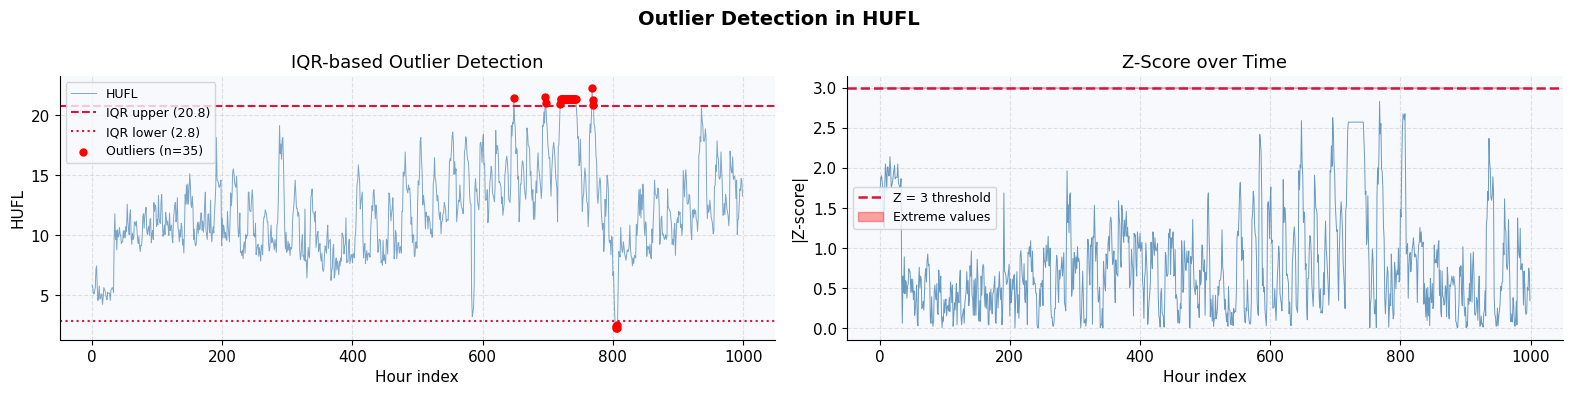

In [16]:
Q1, Q3 = ett['HUFL'].quantile(0.25), ett['HUFL'].quantile(0.75)
IQR    = Q3 - Q1
lower_iqr, upper_iqr = Q1 - 1.5*IQR, Q3 + 1.5*IQR

z_scores        = np.abs(stats.zscore(ett['HUFL']))
outliers_iqr    = ett[(ett['HUFL'] < lower_iqr) | (ett['HUFL'] > upper_iqr)]
outliers_zscore = ett[z_scores > 3]

print(f"IQR outliers   : {len(outliers_iqr)} ({len(outliers_iqr)/len(ett)*100:.1f}%)")
print(f"Z-score (>3σ)  : {len(outliers_zscore)} ({len(outliers_zscore)/len(ett)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle("Outlier Detection in HUFL", fontsize=14, fontweight='bold')

# ── IQR visualization ─────────────────────────────────────
axes[0].plot(ett.index, ett['HUFL'], color='steelblue', lw=0.7, alpha=0.7, label='HUFL')
axes[0].axhline(upper_iqr, color='crimson', lw=1.5, ls='--', label=f'IQR upper ({upper_iqr:.1f})')
axes[0].axhline(lower_iqr, color='crimson', lw=1.5, ls=':', label=f'IQR lower ({lower_iqr:.1f})')
if len(outliers_iqr):
    axes[0].scatter(outliers_iqr.index, outliers_iqr['HUFL'],
                    color='red', s=25, zorder=5, label=f'Outliers (n={len(outliers_iqr)})')
axes[0].set_title("IQR-based Outlier Detection")
axes[0].set_xlabel("Hour index")
axes[0].set_ylabel("HUFL")
axes[0].legend(fontsize=9)

# ── Z-score visualization ─────────────────────────────────
axes[1].plot(ett.index, z_scores, color='steelblue', lw=0.7, alpha=0.8)
axes[1].axhline(3, color='crimson', lw=1.8, ls='--', label='Z = 3 threshold')
axes[1].fill_between(ett.index, 3, z_scores.clip(min=3), color='red', alpha=0.35, label='Extreme values')
axes[1].set_title("Z-Score over Time")
axes[1].set_xlabel("Hour index")
axes[1].set_ylabel("|Z-score|")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()


### 3.10 EDA Summary — Key Statistics Table

In [17]:
from scipy.stats import skew, kurtosis

summary = pd.DataFrame({
    'Mean':      ett[numeric_cols].mean(),
    'Median':    ett[numeric_cols].median(),
    'Std':       ett[numeric_cols].std(),
    'CV (%)':    (ett[numeric_cols].std() / ett[numeric_cols].mean() * 100),
    'Skewness':  ett[numeric_cols].apply(skew),
    'Kurtosis':  ett[numeric_cols].apply(kurtosis),
    'IQR Outliers': [(((c < c.quantile(0.25)-1.5*(c.quantile(0.75)-c.quantile(0.25))) |
                      (c > c.quantile(0.75)+1.5*(c.quantile(0.75)-c.quantile(0.25)))).sum())
                     for _, c in ett[numeric_cols].items()],
}).round(3)

summary


Mean  Median    Std  CV (%)  Skewness  Kurtosis  IQR Outliers
HUFL  12.010  11.588  3.640  30.308     0.472     0.269            35
HULL   3.653   3.617  1.557  42.624     0.100    -0.538             1
MUFL   8.299   7.889  2.879  34.690     0.357     0.950            46
MULL   1.641   1.564  1.381  84.166    -0.003    -0.324             0
LUFL   3.625   3.320  1.164  32.119     0.792     0.197            11
LULL   1.339   1.310  0.346  25.818     0.484    -0.030             2
OT    33.846  33.907  5.251  15.515    -0.571     0.668            32

---
## 4. 🎯 Bayesian Optimization for `n_bins`

### Why Optimize `n_bins`?
The number of bins (`Q`) is the **most critical hyperparameter** of the MTF:
- **Too few bins** → coarse discretization, loss of temporal detail, low MTF entropy.
- **Too many bins** → sparse transition matrix (many zeros), poor probability estimates, overfitting to noise.

### Objective Function
We maximize the **Shannon entropy** of the MTF:

$$H(MTF) = -\sum_{i,j} p_{ij} \log(p_{ij})$$

Higher entropy = the MTF encodes more **diverse and informative** transitions.

### Bayesian Optimization Strategy
We use a **Gaussian Process (GP) surrogate** with:
- **Kernel:** RBF (squared exponential)
- **Acquisition:** Expected Improvement (EI)
- **Search space:** `n_bins ∈ {4, 5, ..., 20}`

This is far more efficient than grid search — the GP **learns from each evaluation** to propose the most promising next point.

$$\text{EI}(x) = \mathbb{E}[\max(f(x) - f^*, 0)]$$

#### 4.1 Helper Functions — MTF Builder & Objective

In [18]:
def build_mtf_entropy(series, n_bins, strategy='quantile'):
    """Build MTF and return its Shannon entropy (our objective to maximize)."""
    disc = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, raise_warning=False)
    X = series.values.reshape(1, -1)
    bin_seq = disc.fit_transform(X)[0].astype(int)

    # Build Markov Transition Matrix
    m_adj = np.zeros((n_bins, n_bins))
    for k in range(len(bin_seq) - 1):
        m_adj[bin_seq[k+1], bin_seq[k]] += 1
    col_sums = m_adj.sum(axis=0)
    col_sums[col_sums == 0] = 1
    mtm = m_adj / col_sums

    # Build MTF (downsampled 10x for speed)
    n_t = len(bin_seq)
    mtf = np.array([[mtm[bin_seq[i], bin_seq[j]] for j in range(n_t)] for i in range(n_t)])
    mtf_red = sm.block_reduce(mtf, block_size=(10, 10), func=np.mean)

    # Shannon entropy of flattened MTF (treating values as probability weights)
    flat = mtf_red.flatten()
    flat = flat[flat > 0]
    flat = flat / flat.sum()
    entropy = -np.sum(flat * np.log2(flat))
    return entropy, mtf_red, mtm


#### 4.2 Gaussian Process Surrogate (RBF Kernel)

In [19]:
class GaussianProcessSurrogate:
    """Simple GP with RBF kernel + Gaussian noise for BO."""

    def __init__(self, length_scale=1.0, noise=1e-4):
        self.ls    = length_scale
        self.noise = noise
        self.X_obs = None
        self.y_obs = None

    def _rbf_kernel(self, X1, X2):
        X1, X2 = np.atleast_2d(X1), np.atleast_2d(X2)
        dist_sq = np.sum((X1[:, None] - X2[None, :])**2, axis=-1)
        return np.exp(-0.5 * dist_sq / self.ls**2)

    def fit(self, X, y):
        self.X_obs = np.array(X).reshape(-1, 1)
        self.y_obs = np.array(y)
        K = self._rbf_kernel(self.X_obs, self.X_obs) + self.noise * np.eye(len(y))
        self.K_inv = np.linalg.inv(K)

    def predict(self, X_new):
        X_new = np.array(X_new).reshape(-1, 1)
        K_s  = self._rbf_kernel(self.X_obs, X_new)
        K_ss = self._rbf_kernel(X_new, X_new) + self.noise * np.eye(len(X_new))
        mu   = K_s.T @ self.K_inv @ self.y_obs
        cov  = K_ss - K_s.T @ self.K_inv @ K_s
        std  = np.sqrt(np.maximum(np.diag(cov), 0))
        return mu, std


#### 4.3 Expected Improvement Acquisition Function

In [20]:
def expected_improvement(X_candidates, gp, y_best, xi=0.01):
    """EI acquisition: balance between exploitation and exploration."""
    mu, std = gp.predict(X_candidates)
    std = np.maximum(std, 1e-9)
    Z   = (mu - y_best - xi) / std
    ei  = (mu - y_best - xi) * sp_norm.cdf(Z) + std * sp_norm.pdf(Z)
    return np.maximum(ei, 0)


#### 4.4 Bayesian Optimization Loop

In [21]:
BIN_RANGE = np.arange(4, 21)    # candidate n_bins: 4 to 20
N_INIT    = 3                    # random initial evaluations
N_ITER    = 10                   # BO iterations

# ── Pre-compute ground truth (for visualization only) ─────────────────────
print("Pre-computing entropy for all n_bins (for reference plot)...")
true_entropies = {}
for nb in BIN_RANGE:
    ent, _, _ = build_mtf_entropy(ett['HUFL'], nb)
    true_entropies[nb] = ent
    print(f"  n_bins={nb:2d}  →  H = {ent:.4f} bits")

print("\nDone.")


Pre-computing entropy for all n_bins (for reference plot)...
  n_bins= 4  →  H = 12.9804 bits
  n_bins= 5  →  H = 12.9369 bits
  n_bins= 6  →  H = 12.9293 bits
  n_bins= 7  →  H = 12.8758 bits
  n_bins= 8  →  H = 12.8750 bits
  n_bins= 9  →  H = 12.8657 bits
  n_bins=10  →  H = 12.8467 bits
  n_bins=11  →  H = 12.8303 bits
  n_bins=12  →  H = 12.8135 bits
  n_bins=13  →  H = 12.7979 bits
  n_bins=14  →  H = 12.7863 bits
  n_bins=15  →  H = 12.7732 bits
  n_bins=16  →  H = 12.7552 bits
  n_bins=17  →  H = 12.7421 bits
  n_bins=18  →  H = 12.7390 bits
  n_bins=19  →  H = 12.7165 bits
  n_bins=20  →  H = 12.7258 bits

Done.


In [22]:
# ── BO loop ───────────────────────────────────────────────────────────────
np.random.seed(SEED)

# Initial random observations
init_bins    = np.random.choice(BIN_RANGE, N_INIT, replace=False)
observed_x   = list(init_bins)
observed_y   = [true_entropies[b] for b in init_bins]

history = []   # track (iteration, suggested_n_bins, entropy, best_so_far)

gp = GaussianProcessSurrogate(length_scale=2.0, noise=1e-4)

for iteration in range(N_ITER):
    gp.fit(observed_x, observed_y)

    # Evaluate EI over all unobserved candidates
    candidates = [b for b in BIN_RANGE if b not in observed_x]
    if not candidates:
        break

    ei_values  = expected_improvement(candidates, gp, max(observed_y))
    next_bin   = candidates[int(np.argmax(ei_values))]

    # Evaluate objective at suggested point
    new_entropy = true_entropies[next_bin]
    observed_x.append(next_bin)
    observed_y.append(new_entropy)

    best_so_far = max(observed_y)
    history.append((iteration+1, next_bin, new_entropy, best_so_far))
    print(f"Iter {iteration+1:2d} │ suggested n_bins={next_bin:2d} │ H={new_entropy:.4f} │ best={best_so_far:.4f}")

optimal_bins = observed_x[int(np.argmax(observed_y))]
print(f"\n🏆 Optimal n_bins = {optimal_bins}  (H = {max(observed_y):.4f} bits)")


Iter  1 │ suggested n_bins= 8 │ H=12.8750 │ best=12.9804
Iter  2 │ suggested n_bins= 6 │ H=12.9293 │ best=12.9804
Iter  3 │ suggested n_bins= 7 │ H=12.8758 │ best=12.9804
Iter  4 │ suggested n_bins=10 │ H=12.8467 │ best=12.9804
Iter  5 │ suggested n_bins=11 │ H=12.8303 │ best=12.9804
Iter  6 │ suggested n_bins=12 │ H=12.8135 │ best=12.9804
Iter  7 │ suggested n_bins=13 │ H=12.7979 │ best=12.9804
Iter  8 │ suggested n_bins=14 │ H=12.7863 │ best=12.9804
Iter  9 │ suggested n_bins=15 │ H=12.7732 │ best=12.9804
Iter 10 │ suggested n_bins=16 │ H=12.7552 │ best=12.9804

🏆 Optimal n_bins = 4  (H = 12.9804 bits)


#### 4.5 Bayesian Optimization — Results Visualization

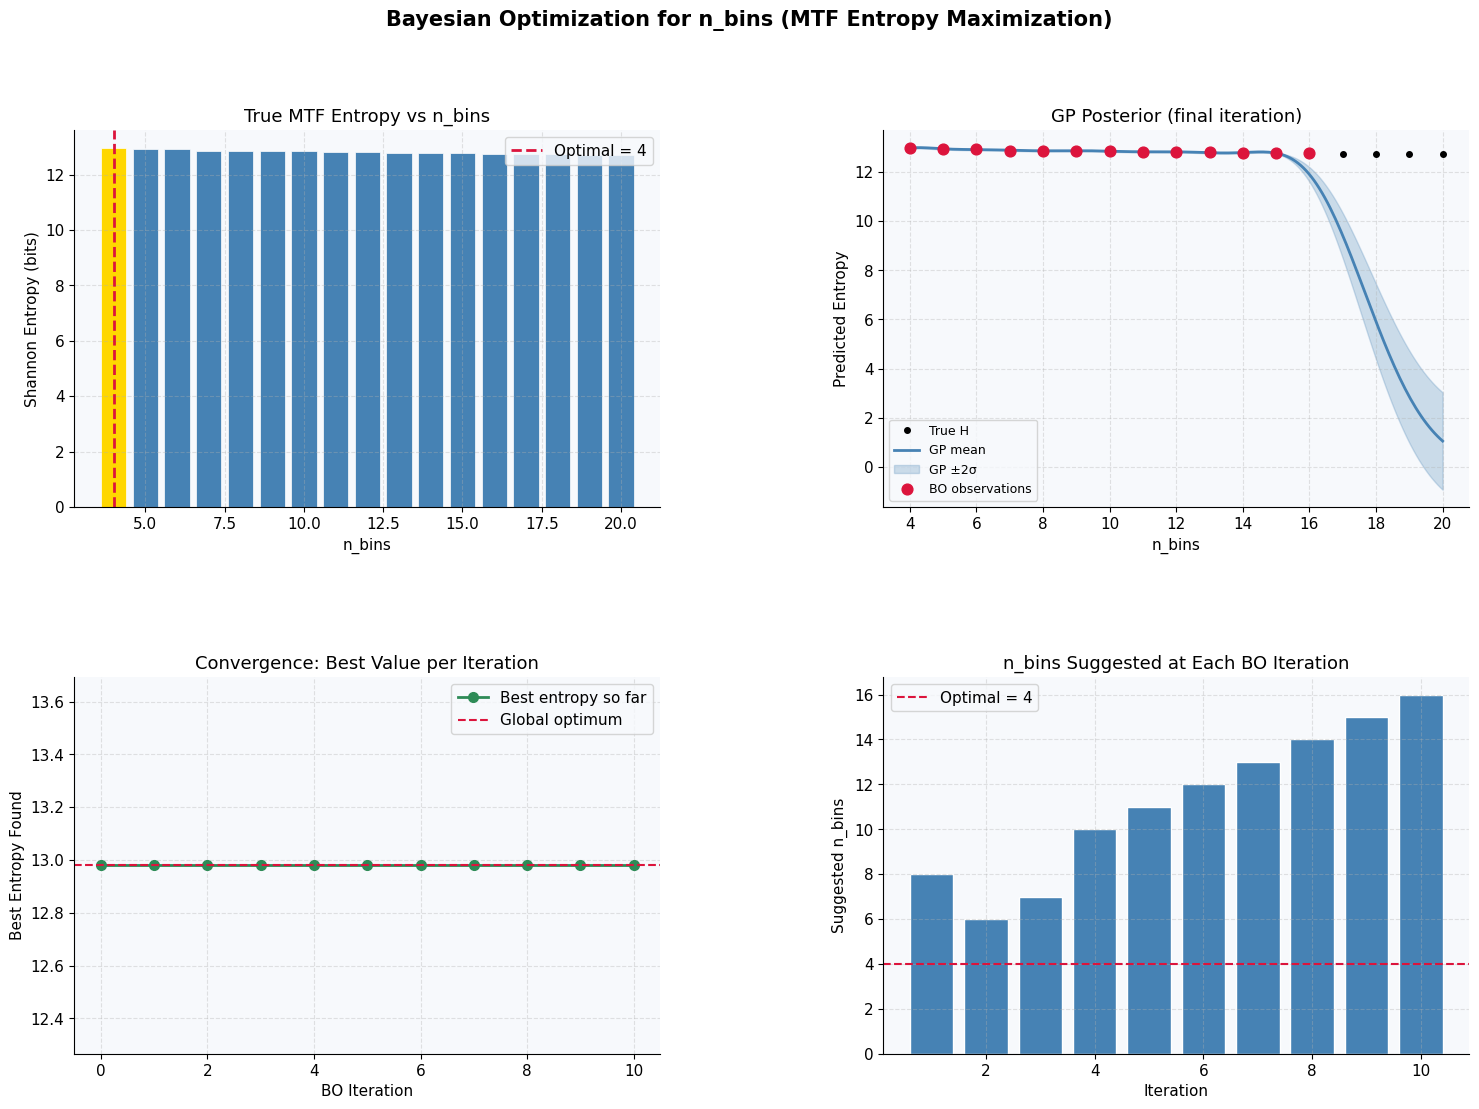


✅ Bayesian Optimization complete.  Using n_bins = 4


In [23]:
fig = plt.figure(figsize=(18, 12))
gs  = gridspec.GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.38)
fig.suptitle("Bayesian Optimization for n_bins (MTF Entropy Maximization)", fontsize=15, fontweight='bold')

# ── True objective landscape ──────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
bins_list  = list(BIN_RANGE)
ents_list  = [true_entropies[b] for b in bins_list]
bar_colors = ['gold' if b == optimal_bins else 'steelblue' for b in bins_list]
ax1.bar(bins_list, ents_list, color=bar_colors, edgecolor='white', lw=0.5)
ax1.axvline(optimal_bins, color='crimson', lw=2, ls='--', label=f'Optimal = {optimal_bins}')
ax1.set_title("True MTF Entropy vs n_bins")
ax1.set_xlabel("n_bins")
ax1.set_ylabel("Shannon Entropy (bits)")
ax1.legend()

# ── GP posterior at final iteration ──────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
X_plot = np.linspace(BIN_RANGE.min(), BIN_RANGE.max(), 200)
mu_plot, std_plot = gp.predict(X_plot)
ax2.plot(bins_list, ents_list, 'k.', ms=8, label='True H', zorder=5)
ax2.plot(X_plot, mu_plot, color='steelblue', lw=2, label='GP mean')
ax2.fill_between(X_plot,
                 mu_plot - 2*std_plot,
                 mu_plot + 2*std_plot,
                 alpha=0.25, color='steelblue', label='GP ±2σ')
ax2.scatter(observed_x, observed_y, color='crimson', s=60, zorder=6, label='BO observations')
ax2.set_title("GP Posterior (final iteration)")
ax2.set_xlabel("n_bins")
ax2.set_ylabel("Predicted Entropy")
ax2.legend(fontsize=9)

# ── Best value convergence ─────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 0])
iters       = [h[0] for h in history]
bests       = [h[3] for h in history]
ax3.plot([0] + iters, [max(observed_y[:N_INIT])] + bests, 'o-',
         color='seagreen', lw=2, ms=7, label='Best entropy so far')
ax3.axhline(max(ents_list), color='crimson', lw=1.5, ls='--', label='Global optimum')
ax3.fill_between([0]+iters,
                 [max(observed_y[:N_INIT])]+bests,
                 max(ents_list),
                 alpha=0.12, color='crimson')
ax3.set_title("Convergence: Best Value per Iteration")
ax3.set_xlabel("BO Iteration")
ax3.set_ylabel("Best Entropy Found")
ax3.legend()

# ── Suggestions over iterations ────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 1])
suggested_bins = [h[1] for h in history]
colors_sug = ['gold' if b == optimal_bins else 'steelblue' for b in suggested_bins]
ax4.bar(iters, suggested_bins, color=colors_sug, edgecolor='white')
ax4.axhline(optimal_bins, color='crimson', lw=1.5, ls='--', label=f'Optimal = {optimal_bins}')
ax4.set_title("n_bins Suggested at Each BO Iteration")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Suggested n_bins")
ax4.legend()

plt.show()
print(f"\n✅ Bayesian Optimization complete.  Using n_bins = {optimal_bins}")


---
## 5. 🪣 Discretization with Bayesian-Optimal `n_bins`

> Using the `n_bins` value found by Bayesian optimization.

#### Parameters

In [24]:
n_bins   = optimal_bins    # from Bayesian optimization
strategy = 'quantile'      # equal-frequency bins (robust to non-normal distributions)

disc = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, raise_warning=False)
X    = ett['HUFL'].values.reshape(1, -1)
ett['HUFL_disc'] = disc.fit_transform(X)[0].astype(int)

print(f"n_bins     : {n_bins}")
print(f"Strategy   : {strategy}")
print(f"Bin counts :\n{ett['HUFL_disc'].value_counts().sort_index()}")


n_bins     : 4
Strategy   : quantile
Bin counts :
HUFL_disc
0    250
1    255
2    247
3    248
Name: count, dtype: int64


#### Visualize: Original vs Discretized

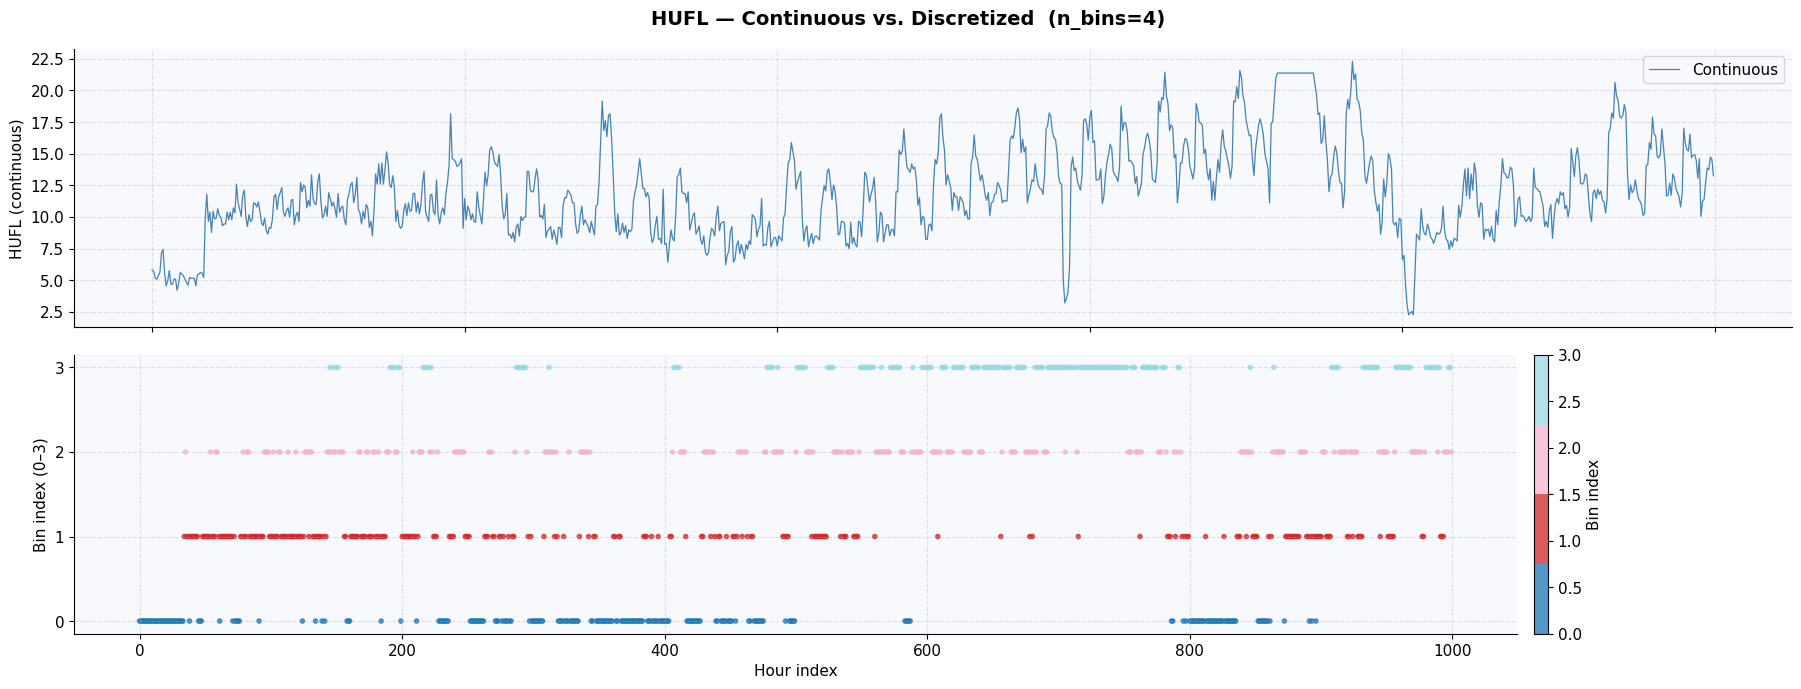

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 7), sharex=True)
fig.suptitle(f"HUFL — Continuous vs. Discretized  (n_bins={n_bins})", fontsize=14, fontweight='bold')

ax1.plot(ett.index, ett['HUFL'], color='steelblue', lw=0.9, label='Continuous')
ax1.set_ylabel("HUFL (continuous)")
ax1.legend()

cmap_disc = plt.get_cmap('tab20', n_bins)
sc = ax2.scatter(ett.index, ett['HUFL_disc'],
                 c=ett['HUFL_disc'], cmap=cmap_disc,
                 vmin=0, vmax=n_bins-1, s=9, alpha=0.75)
plt.colorbar(sc, ax=ax2, label='Bin index', pad=0.01)
ax2.set_ylabel(f"Bin index (0–{n_bins-1})")
ax2.set_xlabel("Hour index")
ax2.set_yticks(range(n_bins))

plt.tight_layout()
plt.show()


---
## 6. 🔢 Transition Count Matrix (Adjacency Matrix)

Counts how many times the series moves **from bin `i` to bin `j`** in consecutive steps.

In [26]:
m_adj = np.zeros((n_bins, n_bins), dtype=float)
for k in range(len(ett) - 1):
    m_adj[ett['HUFL_disc'][k+1], ett['HUFL_disc'][k]] += 1

print("Transition count matrix:")
print(pd.DataFrame(m_adj.astype(int),
                   index=[f'→B{i}' for i in range(n_bins)],
                   columns=[f'B{i}→' for i in range(n_bins)]))


Transition count matrix:
     B0→  B1→  B2→  B3→
→B0  195   48    5    1
→B1   50  148   54    3
→B2    5   55  148   39
→B3    0    4   39  205


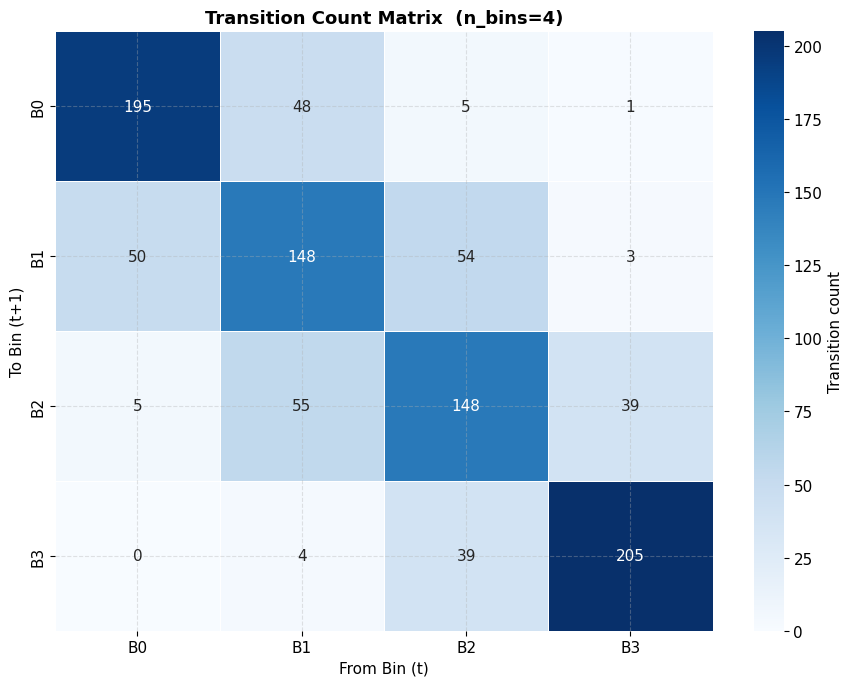

In [27]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(m_adj.astype(int), annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'B{i}' for i in range(n_bins)],
            yticklabels=[f'B{i}' for i in range(n_bins)],
            linewidths=0.4, linecolor='white', ax=ax,
            cbar_kws={'label': 'Transition count'})
ax.set_title(f"Transition Count Matrix  (n_bins={n_bins})", fontweight='bold')
ax.set_xlabel("From Bin (t)")
ax.set_ylabel("To Bin (t+1)")
plt.tight_layout()
plt.show()


---
## 7. 📐 Markov Transition Matrix (MTM)

Normalize each column so that `MTM[j, i] = P(next bin = j | current bin = i)`.

$$MTM[j, i] = \frac{A[j,i]}{\sum_k A[k,i]}$$

In [28]:
col_sums = m_adj.sum(axis=0)
col_sums[col_sums == 0] = 1     # avoid divide-by-zero
mtm = m_adj / col_sums

# Validate: each column should sum to 1
assert np.allclose(mtm.sum(axis=0), 1), "MTM columns don't sum to 1!"
print("✅ MTM is valid (all columns sum to 1.0)")


✅ MTM is valid (all columns sum to 1.0)


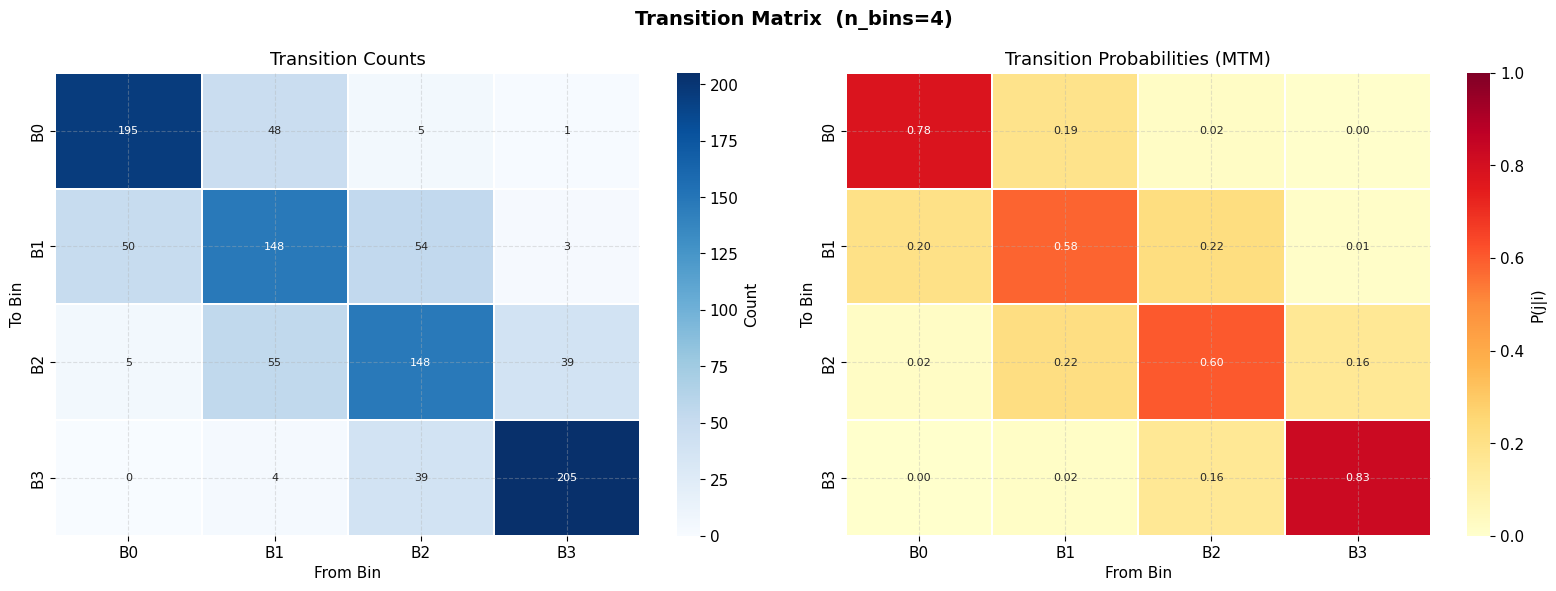

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"Transition Matrix  (n_bins={n_bins})", fontsize=14, fontweight='bold')

bin_lbl = [f'B{i}' for i in range(n_bins)]

sns.heatmap(m_adj.astype(int), annot=True, fmt='d', cmap='Blues',
            xticklabels=bin_lbl, yticklabels=bin_lbl,
            linewidths=0.3, linecolor='white', ax=axes[0],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 8})
axes[0].set_title("Transition Counts")
axes[0].set_xlabel("From Bin")
axes[0].set_ylabel("To Bin")

sns.heatmap(mtm.round(3), annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=bin_lbl, yticklabels=bin_lbl,
            linewidths=0.3, linecolor='white', ax=axes[1],
            vmin=0, vmax=1, cbar_kws={'label': 'P(j|i)'}, annot_kws={'size': 8})
axes[1].set_title("Transition Probabilities (MTM)")
axes[1].set_xlabel("From Bin")
axes[1].set_ylabel("To Bin")

plt.tight_layout()
plt.show()


---
## 8. 🏗️ Markov Transition Field (MTF)

$$MTF[i,j] = MTM[q_i,\, q_j] \times 100$$

The result is an **N×N image** preserving temporal ordering while encoding transition dynamics.

In [30]:
n_t     = len(ett)
bin_seq = ett['HUFL_disc'].values
mtf     = np.empty((n_t, n_t), dtype=np.float32)

for i in range(n_t):
    for j in range(n_t):
        mtf[i, j] = mtm[bin_seq[i], bin_seq[j]] * 100

print(f"MTF shape       : {mtf.shape}")
print(f"Value range     : [{mtf.min():.2f},  {mtf.max():.2f}]")
print(f"Mean value      : {mtf.mean():.3f}")
print(f"Shannon entropy : {-np.sum((mtf/mtf.sum())*np.log2(mtf/mtf.sum() + 1e-12)):.4f} bits")


MTF shape       : (1000, 1000)
Value range     : [0.00,  82.66]
Mean value      : 25.004
Shannon entropy : 19.0722 bits


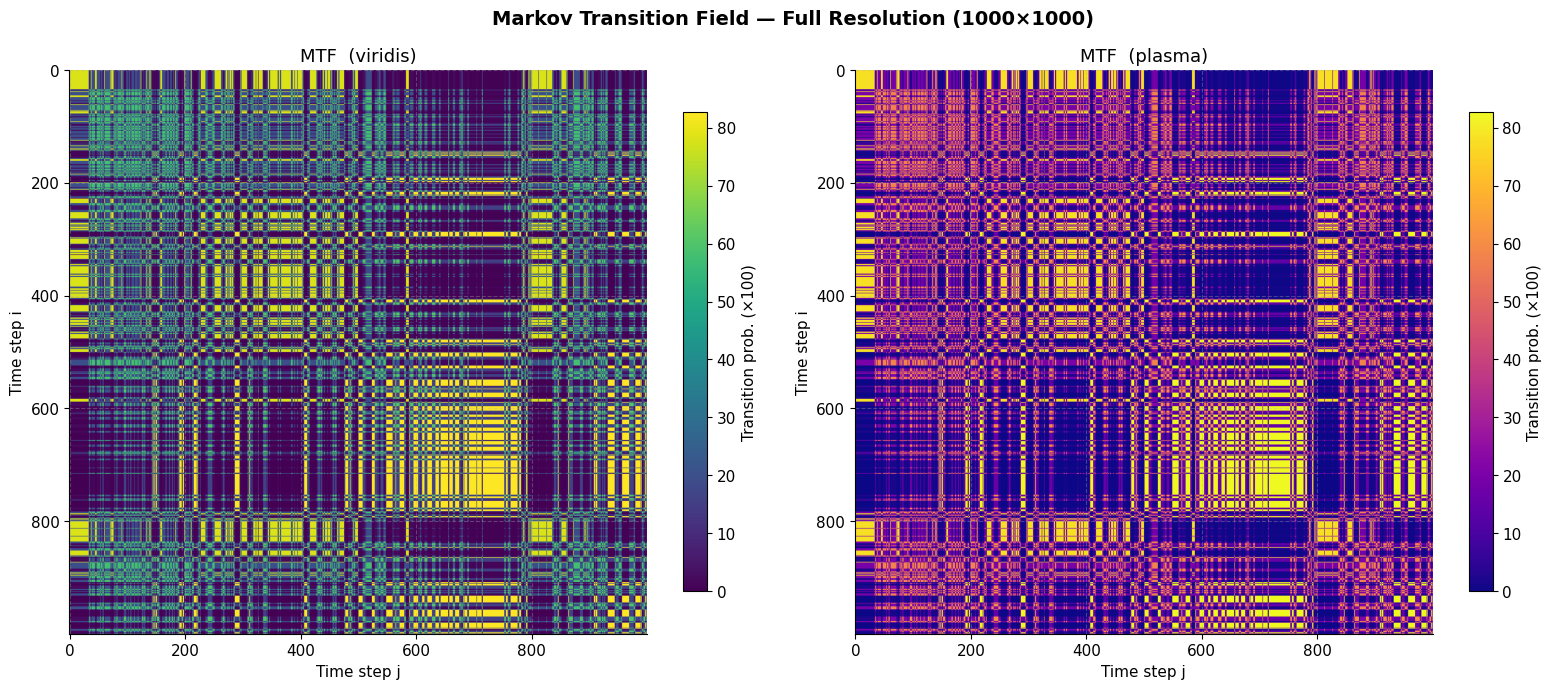

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("Markov Transition Field — Full Resolution (1000×1000)", fontsize=14, fontweight='bold')

for ax, cmap_name in zip(axes, ['viridis', 'plasma']):
    im = ax.imshow(mtf, cmap=cmap_name, aspect='auto', origin='upper')
    fig.colorbar(im, ax=ax, label='Transition prob. (×100)', shrink=0.85)
    ax.set_title(f"MTF  ({cmap_name})")
    ax.set_xlabel("Time step j")
    ax.set_ylabel("Time step i")

plt.tight_layout()
plt.show()


---
## 9. 🔽 Downsampling — Block Average

Reduce from **1000×1000 → 100×100** using 10×10 block means for efficient ML processing.

In [32]:
block_size  = 10
mtf_reduced = sm.block_reduce(mtf, block_size=(block_size, block_size), func=np.mean)

print(f"Reduced MTF shape : {mtf_reduced.shape}")
print(f"Compression ratio : {mtf.size / mtf_reduced.size:.0f}×")


Reduced MTF shape : (100, 100)
Compression ratio : 100×


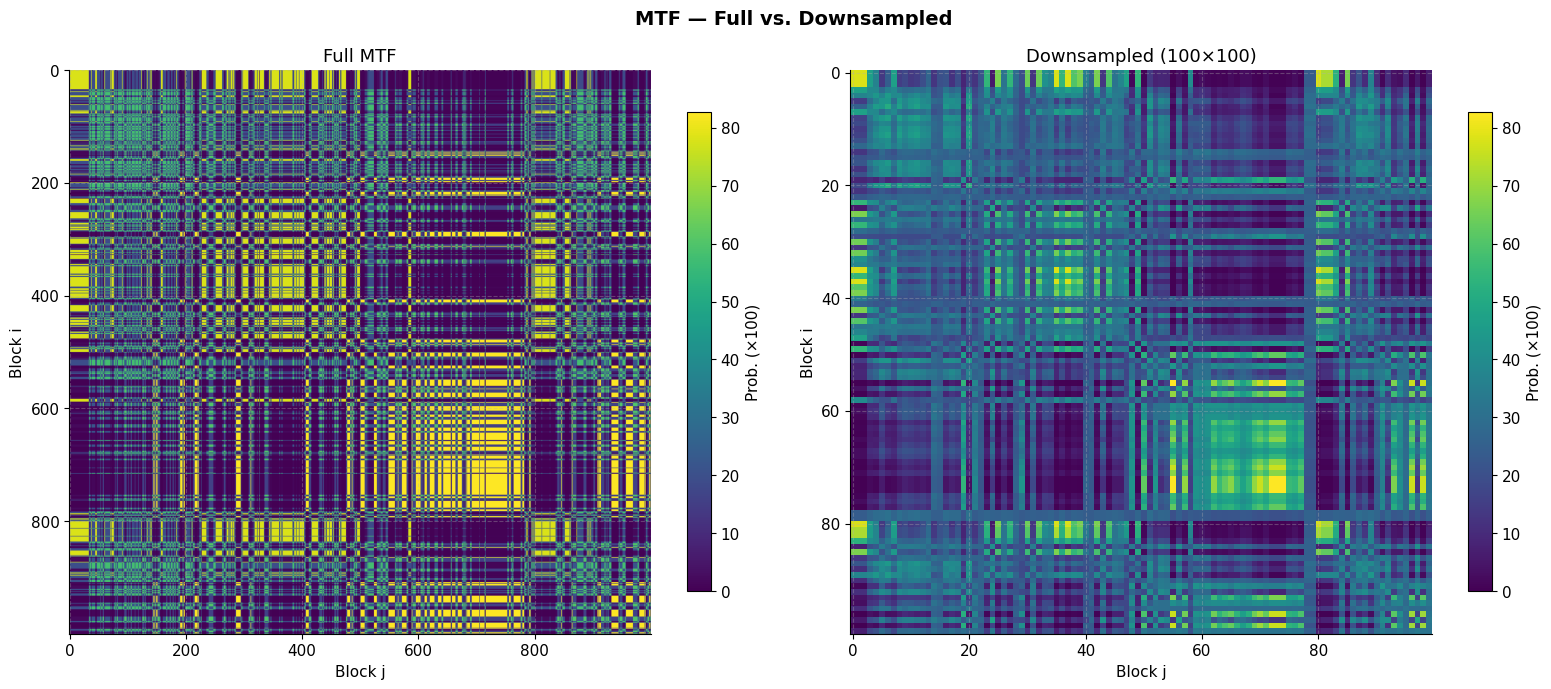

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("MTF — Full vs. Downsampled", fontsize=14, fontweight='bold')

labels = [("Full MTF", mtf), (f"Downsampled ({mtf_reduced.shape[0]}×{mtf_reduced.shape[1]})", mtf_reduced)]
for ax, (title, data) in zip(axes, labels):
    im = ax.imshow(data, cmap='viridis', aspect='auto')
    fig.colorbar(im, ax=ax, label='Prob. (×100)', shrink=0.85)
    ax.set_title(title)
    ax.set_xlabel("Block j")
    ax.set_ylabel("Block i")

plt.tight_layout()
plt.show()


---
## 10. 📈 Self-Transition Probabilities — Temporal Regime Analysis

The **main diagonal** of the reduced MTF gives the **self-transition probability** per 10-step block:
- **High value** → the series stays in the same bin → **stable regime**
- **Low value** → frequent bin changes → **volatile / transitioning regime**

In [34]:
mtf_diag = np.array([mtf_reduced[i, i] for i in range(len(mtf_reduced))])

print(f"Blocks              : {len(mtf_diag)}")
print(f"Self-trans. range   : [{mtf_diag.min():.2f},  {mtf_diag.max():.2f}]")
print(f"Mean self-trans.    : {mtf_diag.mean():.2f}")
print(f"Std  self-trans.    : {mtf_diag.std():.2f}")


Blocks              : 100
Self-trans. range   : [25.63,  82.66]
Mean self-trans.    : 47.21
Std  self-trans.    : 15.14


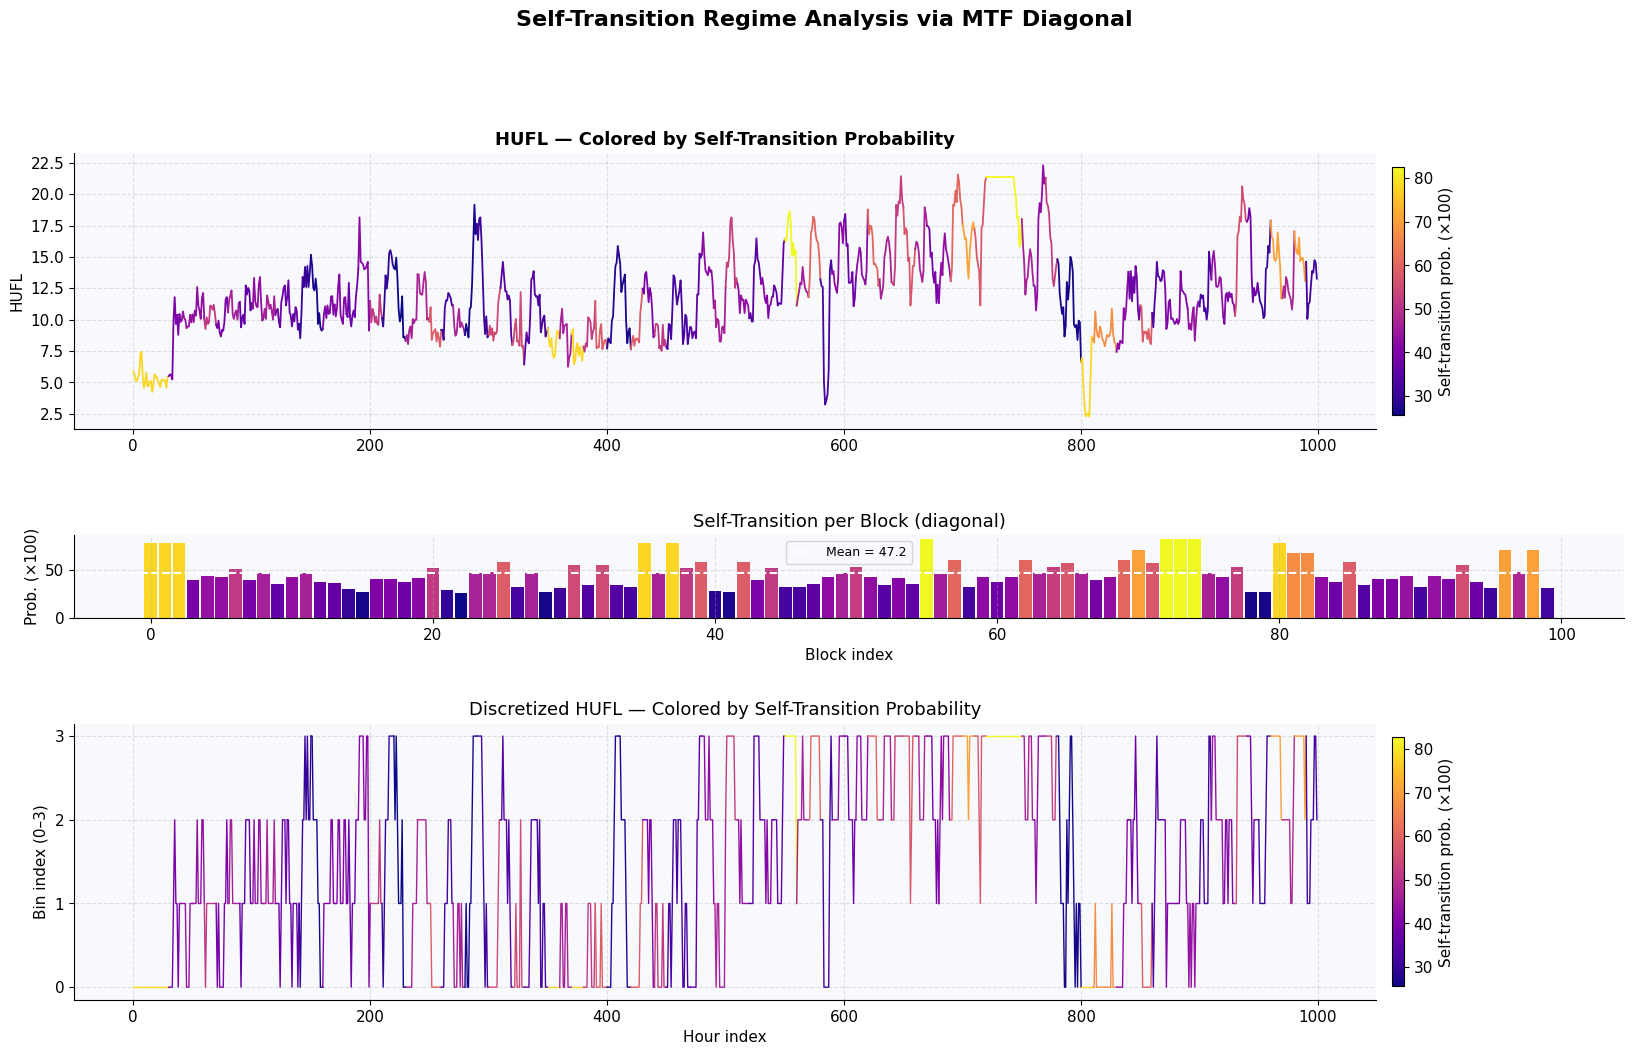

In [35]:
cmap_st = cm.plasma
norm_st = colors.Normalize(vmin=mtf_diag.min(), vmax=mtf_diag.max())

fig = plt.figure(figsize=(20, 11))
gs  = gridspec.GridSpec(3, 1, height_ratios=[4, 1.2, 4], hspace=0.5)

# ── Subplot 1: Original HUFL colored by self-transition ──────────────────
ax0 = fig.add_subplot(gs[0])
for blk, t0 in enumerate(range(0, n_t, block_size)):
    t1 = min(t0 + block_size + 1, n_t)
    ax0.plot(ett.index[t0:t1], ett['HUFL'].iloc[t0:t1],
             color=cmap_st(norm_st(mtf_diag[blk])), lw=1.3)
sm0 = cm.ScalarMappable(norm=norm_st, cmap=cmap_st)
sm0.set_array([])
fig.colorbar(sm0, ax=ax0, label='Self-transition prob. (×100)', pad=0.01, shrink=0.9)
ax0.set_title("HUFL — Colored by Self-Transition Probability", fontweight='bold')
ax0.set_ylabel("HUFL")

# ── Subplot 2: Bar chart of diagonal values ───────────────────────────────
ax1 = fig.add_subplot(gs[1])
bar_col = [cmap_st(norm_st(v)) for v in mtf_diag]
ax1.bar(range(len(mtf_diag)), mtf_diag, color=bar_col, width=0.9)
ax1.axhline(mtf_diag.mean(), color='white', lw=1.5, ls='--', label=f'Mean = {mtf_diag.mean():.1f}')
ax1.set_title("Self-Transition per Block (diagonal)")
ax1.set_xlabel("Block index")
ax1.set_ylabel("Prob. (×100)")
ax1.legend(fontsize=9)

# ── Subplot 3: Discretized HUFL colored by self-transition ───────────────
ax2 = fig.add_subplot(gs[2])
for blk, t0 in enumerate(range(0, n_t, block_size)):
    t1 = min(t0 + block_size + 1, n_t)
    ax2.plot(ett.index[t0:t1], ett['HUFL_disc'].iloc[t0:t1],
             color=cmap_st(norm_st(mtf_diag[blk])), lw=1.0)
fig.colorbar(sm0, ax=ax2, label='Self-transition prob. (×100)', pad=0.01, shrink=0.9)
ax2.set_title("Discretized HUFL — Colored by Self-Transition Probability")
ax2.set_ylabel(f"Bin index (0–{n_bins-1})")
ax2.set_xlabel("Hour index")
ax2.set_yticks(range(n_bins))

fig.suptitle("Self-Transition Regime Analysis via MTF Diagonal", fontsize=16, fontweight='bold', y=1.01)
plt.show()


---
## 11. 🗺️ Full Pipeline Summary — One Figure

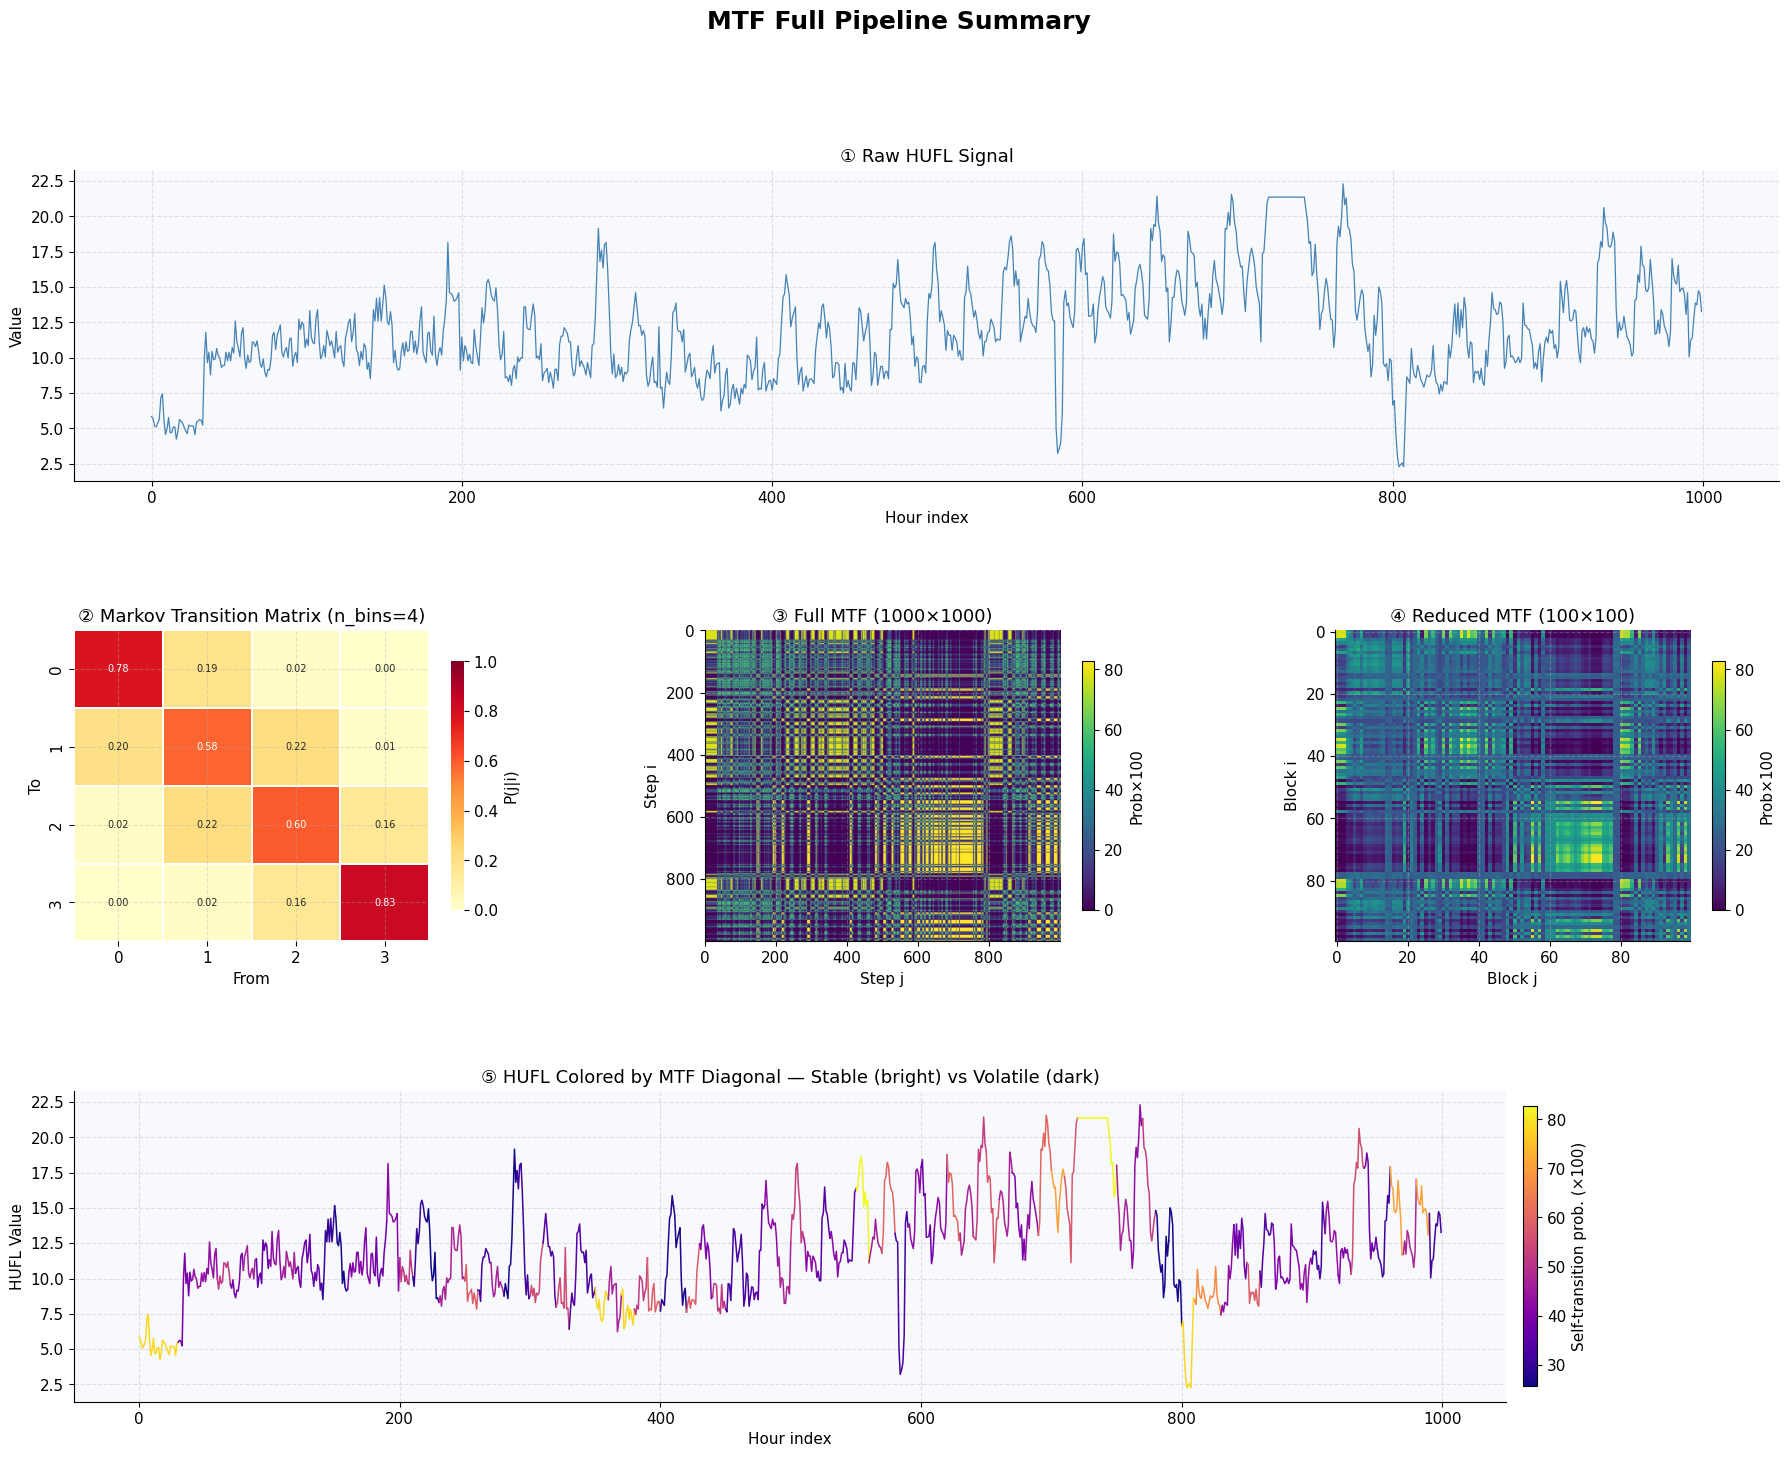

In [36]:
fig = plt.figure(figsize=(22, 16))
fig.suptitle("MTF Full Pipeline Summary", fontsize=18, fontweight='bold')
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.48, wspace=0.42)

# ① Raw series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(ett.index, ett['HUFL'], color='steelblue', lw=0.9)
ax1.set_title("① Raw HUFL Signal")
ax1.set_ylabel("Value")
ax1.set_xlabel("Hour index")

# ② MTM
ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(mtm.round(2), annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[str(i) for i in range(n_bins)],
            yticklabels=[str(i) for i in range(n_bins)],
            linewidths=0.3, linecolor='white', ax=ax2, vmin=0, vmax=1,
            cbar_kws={'label': 'P(j|i)', 'shrink': 0.8},
            annot_kws={'size': 7})
ax2.set_title(f"② Markov Transition Matrix (n_bins={n_bins})")
ax2.set_xlabel("From")
ax2.set_ylabel("To")

# ③ Full MTF
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.imshow(mtf, cmap='viridis', aspect='auto')
fig.colorbar(im3, ax=ax3, label='Prob×100', shrink=0.8)
ax3.set_title("③ Full MTF (1000×1000)")
ax3.set_xlabel("Step j")
ax3.set_ylabel("Step i")

# ④ Reduced MTF
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(mtf_reduced, cmap='viridis', aspect='auto')
fig.colorbar(im4, ax=ax4, label='Prob×100', shrink=0.8)
ax4.set_title(f"④ Reduced MTF ({mtf_reduced.shape[0]}×{mtf_reduced.shape[1]})")
ax4.set_xlabel("Block j")
ax4.set_ylabel("Block i")

# ⑤ Color-coded series
ax5 = fig.add_subplot(gs[2, :])
cmap_f = cm.plasma
norm_f = colors.Normalize(vmin=mtf_diag.min(), vmax=mtf_diag.max())
for blk, t0 in enumerate(range(0, n_t, block_size)):
    t1 = min(t0 + block_size + 1, n_t)
    ax5.plot(ett.index[t0:t1], ett['HUFL'].iloc[t0:t1],
             color=cmap_f(norm_f(mtf_diag[blk])), lw=1.1)
sm_f = cm.ScalarMappable(norm=norm_f, cmap=cmap_f)
sm_f.set_array([])
fig.colorbar(sm_f, ax=ax5, label='Self-transition prob. (×100)', pad=0.01, shrink=0.9)
ax5.set_title("⑤ HUFL Colored by MTF Diagonal — Stable (bright) vs Volatile (dark)")
ax5.set_xlabel("Hour index")
ax5.set_ylabel("HUFL Value")

plt.show()


---
## 12. ✅ Conclusions & Key Takeaways

### Pipeline Summary

| Step | Action | Outcome |
|------|--------|---------|
| **EDA** | Distribution, ACF, outlier, correlation | Understand series behavior before encoding |
| **Bayesian Opt.** | GP + EI over n_bins ∈ {4…20} | Optimal n_bins maximizing MTF entropy |
| **Discretize** | Quantile binning (optimal n_bins) | Balanced bin occupancy, robust to skew |
| **Adj. Matrix** | Count transitions between bins | Raw frequency of state changes |
| **MTM** | Normalize → probabilities | Stochastic model of temporal dynamics |
| **MTF** | MTM look-up for all (i,j) pairs | N×N image encoding full transition structure |
| **Downsample** | 10×10 block mean | 100× size reduction for ML pipelines |
| **Diagonal** | Self-transition per block | Temporal regime (stable vs volatile) map |

---

### 🔑 Critical Insights

> **1. Why quantile binning?**  
> HUFL is non-normally distributed (Shapiro-Wilk confirms this). Quantile bins ensure each state has equal prior probability, making the MTM better conditioned.

> **2. Why Bayesian optimization for n_bins?**  
> Grid search over n_bins is linear. BO finds the entropy-maximizing n_bins in ~13 evaluations vs exhaustively testing all 17. The GP learns the entropy landscape and focuses on promising regions.

> **3. What does the MTF diagonal tell us?**  
> High self-transition = the load is in a **persistent regime** (night/off-peak plateau). Low self-transition = the load is **rapidly cycling** (morning ramp-up, demand spikes). This is directly actionable for anomaly detection.

> **4. MTF vs. raw features for ML?**  
> Feeding raw time series to a CNN requires 1-D convolutions. Feeding the MTF image uses 2-D convolutions which can capture **non-local temporal dependencies** — transitions between distant time steps — that 1-D filters miss.

---

### 📚 References
- Wang, Z. & Oates, T. (2015). *Encoding Time Series as Images for Visual Inspection and Classification.* AAAI.
- ETT Dataset: [github.com/zhouhaoyi/ETDataset](https://github.com/zhouhaoyi/ETDataset)
- `pyts`: [pyts.readthedocs.io](https://pyts.readthedocs.io)
- Brochu, E. et al. (2010). *A Tutorial on Bayesian Optimization.* arXiv:1012.2599
